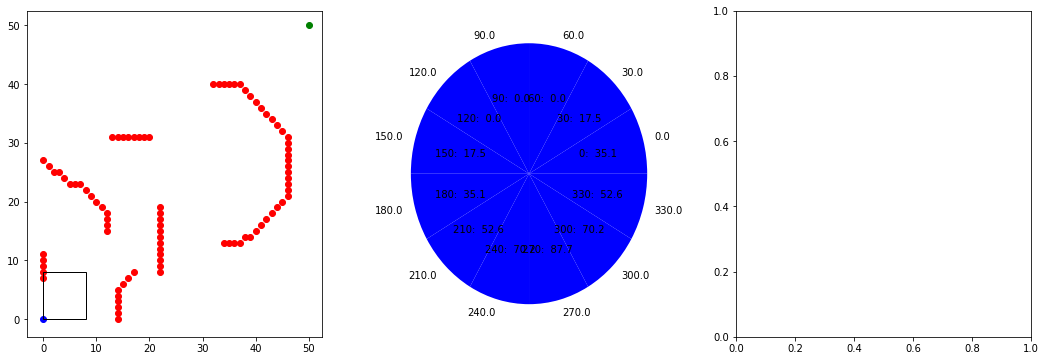

index, angle, certainty
0 0.0 35.09090909090909
1 30.0 17.545454545454547
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 17.545454545454547
6 180.0 35.09090909090909
7 210.0 52.63636363636363
8 240.0 70.18181818181819
9 270.0 87.72727272727273
10 300.0 70.18181818181819
11 330.0 52.63636363636363

robot: step: best angle = 45.0
robot: discrete_location = (0.0, 0.0)
path_planner: generate_histogram: robot_location = (0.0, 0.0)
path_planner: generate_histogram: active_region = (0, 0, 8, 8)


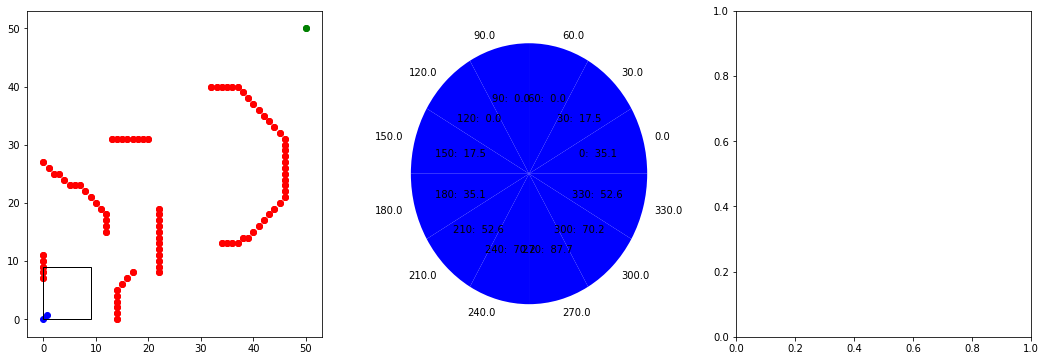

index, angle, certainty
0 0.0 35.09090909090909
1 30.0 17.545454545454547
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 17.545454545454547
6 180.0 35.09090909090909
7 210.0 52.63636363636363
8 240.0 70.18181818181819
9 270.0 87.72727272727273
10 300.0 70.18181818181819
11 330.0 52.63636363636363

robot: step: best angle = 45.0
robot: discrete_location = (1.0, 1.0)
path_planner: generate_histogram: robot_location = (1.0, 1.0)
path_planner: generate_histogram: active_region = (0, 0, 9, 9)


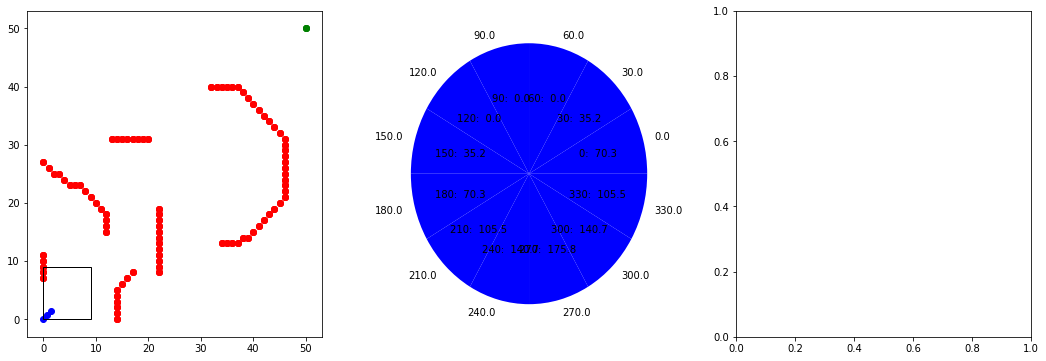

index, angle, certainty
0 0.0 70.3356672105157
1 30.0 35.16783360525785
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 35.16783360525785
6 180.0 70.3356672105157
7 210.0 105.50350081577353
8 240.0 140.6713344210314
9 270.0 175.83916802628923
10 300.0 140.6713344210314
11 330.0 105.50350081577353

robot: step: best angle = 45.0
robot: discrete_location = (2.0, 2.0)
path_planner: generate_histogram: robot_location = (2.0, 2.0)
path_planner: generate_histogram: active_region = (0, 0, 10, 10)


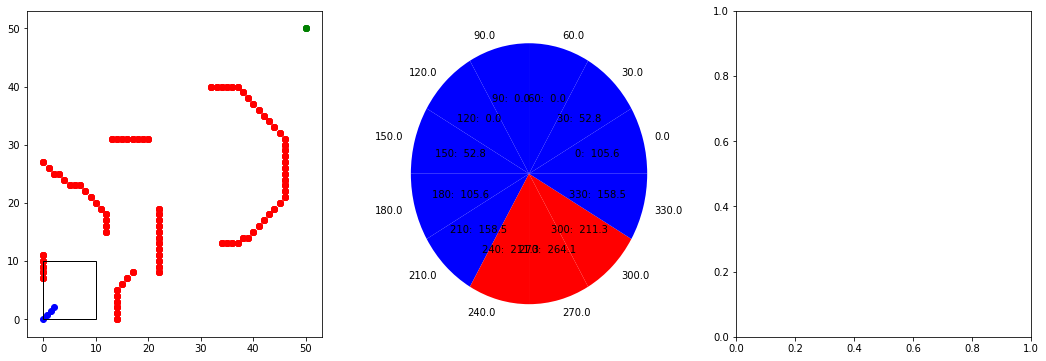

index, angle, certainty
0 0.0 105.63821272422693
1 30.0 52.819106362113466
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 52.819106362113466
6 180.0 105.63821272422693
7 210.0 158.45731908634042
8 240.0 211.27642544845386
9 270.0 264.0955318105673
10 300.0 211.27642544845386
11 330.0 158.45731908634042

robot: step: best angle = 120.0
robot: discrete_location = (1.0, 2.0)
path_planner: generate_histogram: robot_location = (1.0, 2.0)
path_planner: generate_histogram: active_region = (0, 0, 9, 10)


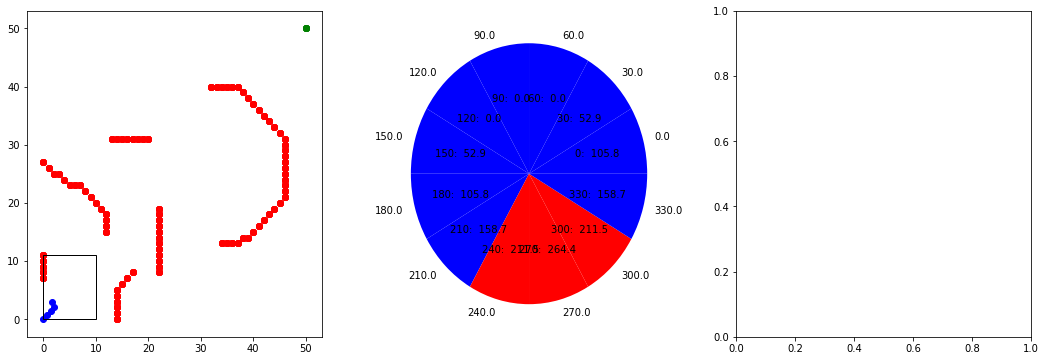

index, angle, certainty
0 0.0 105.77220911713518
1 30.0 52.88610455856759
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 52.88610455856759
6 180.0 105.77220911713518
7 210.0 158.65831367570277
8 240.0 211.54441823427035
9 270.0 264.43052279283796
10 300.0 211.54441823427035
11 330.0 158.65831367570277

robot: step: best angle = 120.0
robot: discrete_location = (1.0, 3.0)
path_planner: generate_histogram: robot_location = (1.0, 3.0)
path_planner: generate_histogram: active_region = (0, 0, 9, 11)


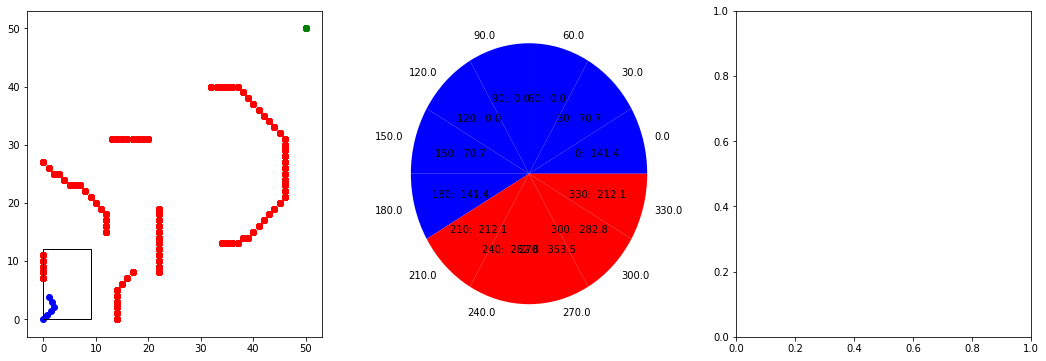

index, angle, certainty
0 0.0 141.38618991247742
1 30.0 70.69309495623871
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 70.69309495623871
6 180.0 141.38618991247742
7 210.0 212.07928486871614
8 240.0 282.77237982495484
9 270.0 353.46547478119356
10 300.0 282.77237982495484
11 330.0 212.07928486871614

robot: step: best angle = 43.35315587425951
robot: discrete_location = (1.0, 4.0)
path_planner: generate_histogram: robot_location = (1.0, 4.0)
path_planner: generate_histogram: active_region = (0, 0, 9, 12)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:113: UserWarning: path_planner: the entire histogram is below valley_threshold = 200, setting best angle to robot_to_target_angle = 0.7566553111361491
  warnings.warn("path_planner: the entire histogram is below valley_threshold = %s, setting best angle to robot_to_target_angle = %s" % (self.valley_threshold, robot_to_target_angle))


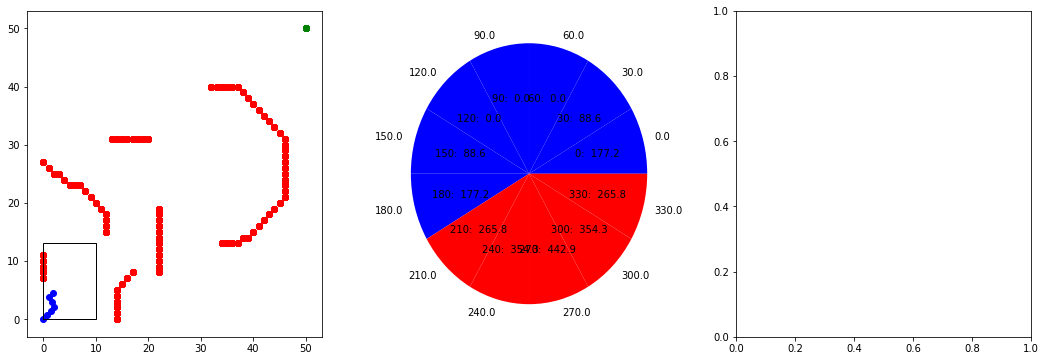

index, angle, certainty
0 0.0 177.1748667015377
1 30.0 88.58743335076885
2 60.0 0.0
3 90.0 0.0
4 120.0 0.0
5 150.0 88.58743335076885
6 180.0 177.1748667015377
7 210.0 265.76230005230656
8 240.0 354.3497334030754
9 270.0 442.93716675384434
10 300.0 354.3497334030754
11 330.0 265.76230005230656

robot: step: best angle = 43.35315587425951
robot: discrete_location = (2.0, 5.0)
path_planner: generate_histogram: robot_location = (2.0, 5.0)
path_planner: generate_histogram: active_region = (0, 0, 10, 13)


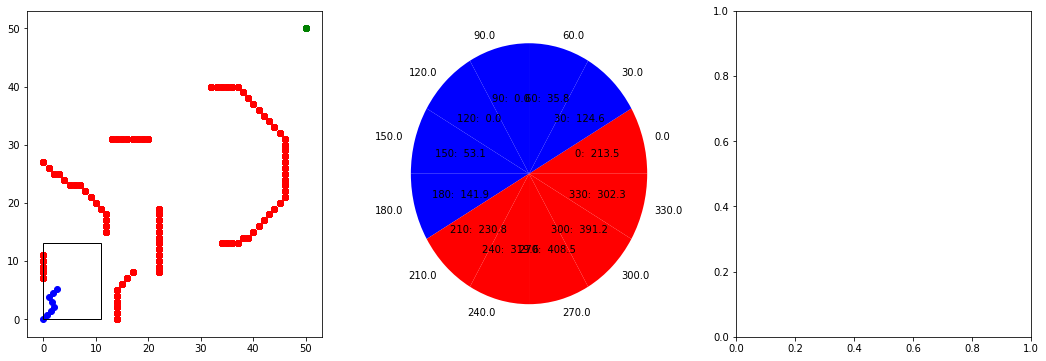

index, angle, certainty
0 0.0 213.48494114858434
1 30.0 124.63183519246444
2 60.0 35.778729236344525
3 90.0 0.0
4 120.0 0.0
5 150.0 53.07437671977538
6 180.0 141.92748267589528
7 210.0 230.7805886320152
8 240.0 319.6336945881351
9 270.0 408.48680054425495
10 300.0 391.1911530608241
11 330.0 302.33804710470423

robot: step: best angle = 43.35315587425951
robot: discrete_location = (3.0, 5.0)
path_planner: generate_histogram: robot_location = (3.0, 5.0)
path_planner: generate_histogram: active_region = (0, 0, 11, 13)


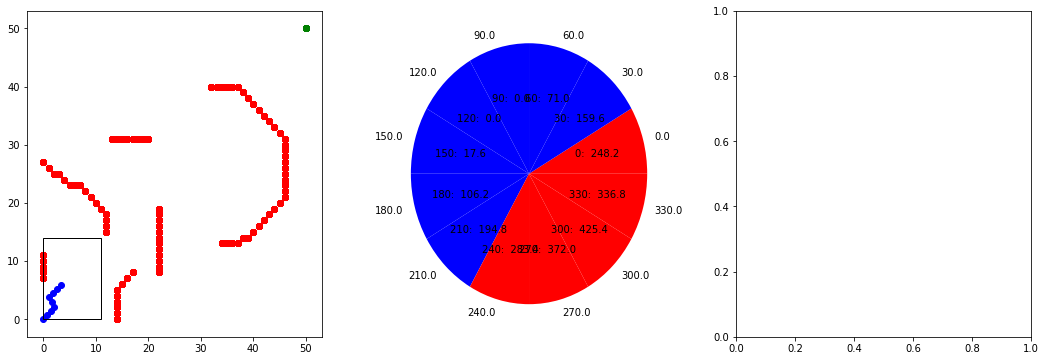

index, angle, certainty
0 0.0 248.23146914206507
1 30.0 159.6303189411494
2 60.0 71.02916874023377
3 90.0 0.0
4 120.0 0.0
5 150.0 17.571981460681876
6 180.0 106.17313166159751
7 210.0 194.77428186251316
8 240.0 283.37543206342883
9 270.0 371.9765822643445
10 300.0 425.4337695438963
11 330.0 336.83261934298065

robot: step: best angle = 43.35315587425951
robot: discrete_location = (4.0, 6.0)
path_planner: generate_histogram: robot_location = (4.0, 6.0)
path_planner: generate_histogram: active_region = (0, 0, 12, 14)


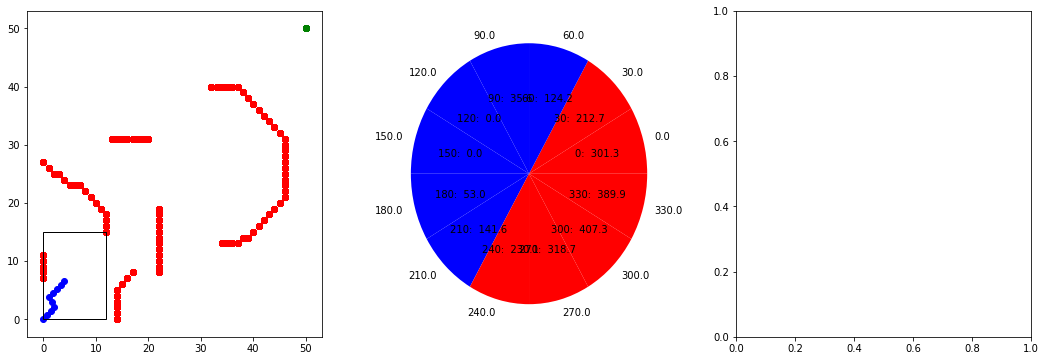

index, angle, certainty
0 0.0 301.3126452924323
1 30.0 212.73584711675437
2 60.0 124.15904894107639
3 90.0 35.582250765398435
4 120.0 0.0
5 150.0 0.0
6 180.0 52.99454741027952
7 210.0 141.57134558595746
8 240.0 230.14814376163542
9 270.0 318.7249419373134
10 300.0 407.3017401129913
11 330.0 389.88944346811024

robot: step: best angle = 43.35315587425951
robot: discrete_location = (4.0, 7.0)
path_planner: generate_histogram: robot_location = (4.0, 7.0)
path_planner: generate_histogram: active_region = (0, 0, 12, 15)


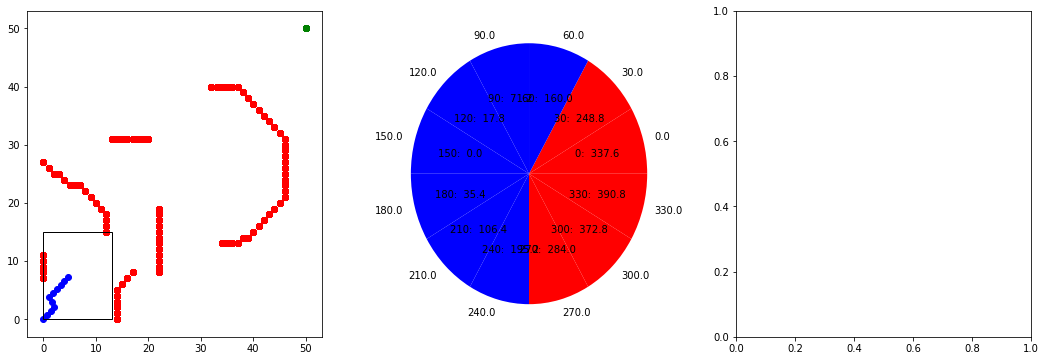

index, angle, certainty
0 0.0 337.60440644809586
1 30.0 248.80914243265124
2 60.0 160.01387841720666
3 90.0 71.21861440176207
4 120.0 17.818181818181817
5 150.0 0.0
6 180.0 35.39483143186433
7 210.0 106.37191362912709
8 240.0 195.1671776445717
9 270.0 283.9624416600163
10 300.0 372.75770567546084
11 330.0 390.76330682717673

robot: step: best angle = 43.35315587425951
robot: discrete_location = (5.0, 7.0)
path_planner: generate_histogram: robot_location = (5.0, 7.0)
path_planner: generate_histogram: active_region = (0, 0, 13, 15)


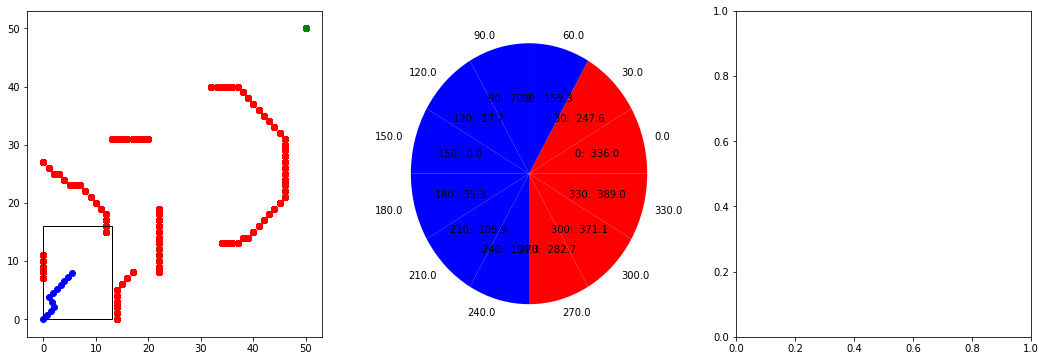

index, angle, certainty
0 0.0 336.03282130184147
1 30.0 247.6435722521147
2 60.0 159.25432320238795
3 90.0 70.86507415266115
4 120.0 17.727272727272727
5 150.0 0.0
6 180.0 35.251447624338354
7 210.0 105.9134239467924
8 240.0 194.30267299651916
9 270.0 282.69192204624596
10 300.0 371.08117109597276
11 330.0 388.9675248970228

robot: step: best angle = 43.35315587425951
robot: discrete_location = (6.0, 8.0)
path_planner: generate_histogram: robot_location = (6.0, 8.0)
path_planner: generate_histogram: active_region = (0, 0, 14, 16)


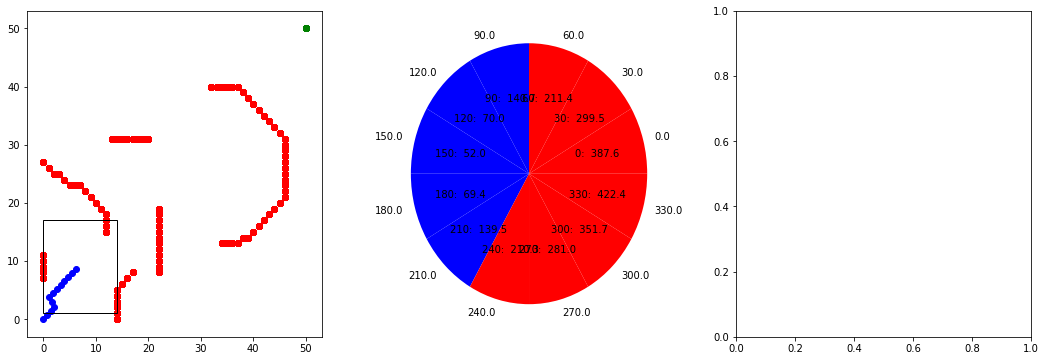

index, angle, certainty
0 0.0 387.5567363832701
1 30.0 299.48385313903674
2 60.0 211.41096989480332
3 90.0 140.68176442717967
4 120.0 69.95255895955599
5 150.0 52.03103332982921
6 180.0 69.37471110643895
7 210.0 139.52606872094557
8 240.0 210.25527418856925
9 270.0 280.9844796561929
10 300.0 351.71368512381656
11 330.0 422.4428905914402

robot: step: best angle = 43.35315587425951
robot: discrete_location = (6.0, 9.0)
path_planner: generate_histogram: robot_location = (6.0, 9.0)
path_planner: generate_histogram: active_region = (0, 1, 14, 17)


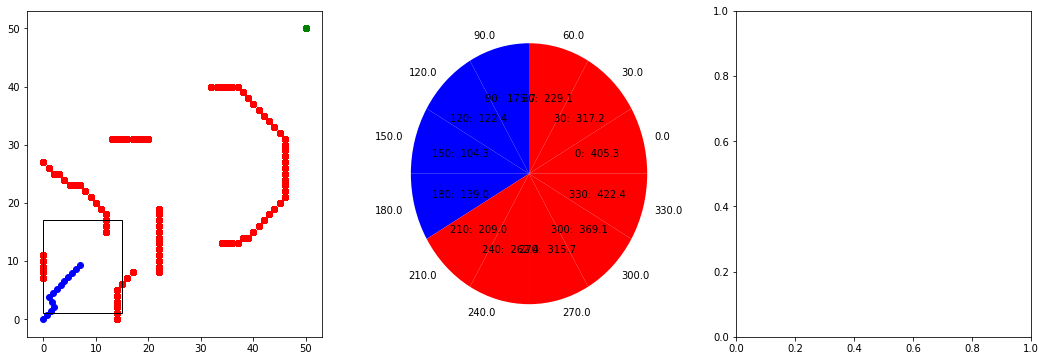

index, angle, certainty
0 0.0 405.3031035767532
1 30.0 317.1953431859596
2 60.0 229.08758279516596
3 90.0 175.73392914696035
4 120.0 122.38027549875473
5 150.0 104.26232022776414
6 180.0 139.0164269703522
7 210.0 209.00623209015524
8 240.0 262.3598857383608
9 270.0 315.7135393865664
10 300.0 369.06719303477206
11 330.0 422.4208466829777

robot: step: best angle = 43.35315587425951
robot: discrete_location = (7.0, 10.0)
path_planner: generate_histogram: robot_location = (7.0, 10.0)
path_planner: generate_histogram: active_region = (0, 2, 15, 18)


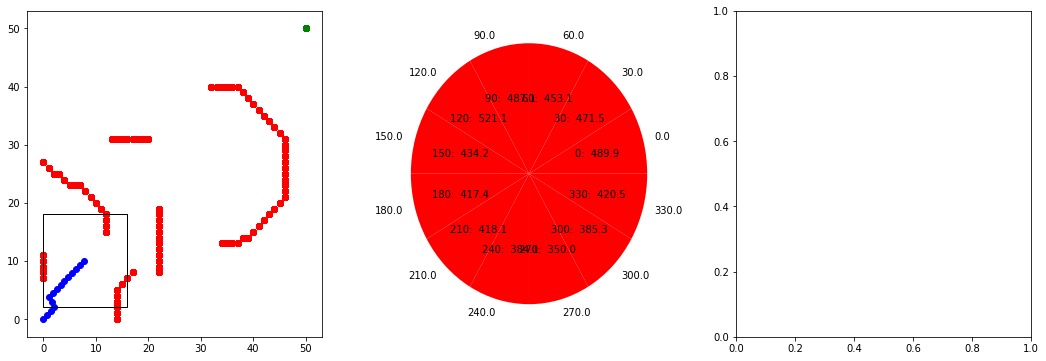

index, angle, certainty
0 0.0 489.86631493125515
1 30.0 471.474179308091
2 60.0 453.08204368492676
3 90.0 487.100485993143
4 120.0 521.1189283013592
5 150.0 434.19482089462076
6 180.0 417.36462705088144
7 210.0 418.07342704242706
8 240.0 384.0549847342108
9 270.0 350.0365424259945
10 300.0 385.25887189289807
11 330.0 420.4812013598017

robot: step: best angle = 285.0
robot: discrete_location = (7.0, 9.0)
path_planner: generate_histogram: robot_location = (7.0, 9.0)
path_planner: generate_histogram: active_region = (0, 1, 15, 17)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:108: UserWarning: path_planner: the entire polar histogram is above valley threshold = 200, setting best angle to least likely bin middle angle = 285.0
  warnings.warn("path_planner: the entire polar histogram is above valley threshold = %s, setting best angle to least likely bin middle angle = %s" % (self.valley_threshold, middle_angle))


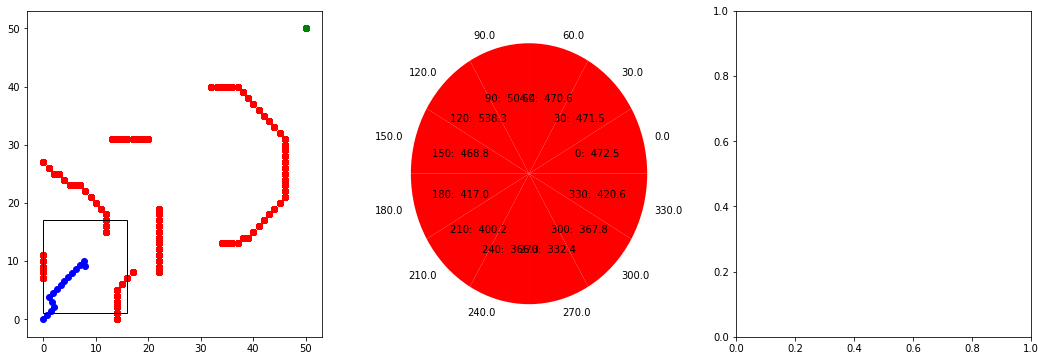

index, angle, certainty
0 0.0 472.49889911054595
1 30.0 471.52513430875604
2 60.0 470.5513695069662
3 90.0 504.44918880127176
4 120.0 538.3470080955775
5 150.0 468.82226768499385
6 180.0 417.004194346724
7 210.0 400.2451048538044
8 240.0 366.34728555949874
9 270.0 332.44946626519305
10 300.0 367.79241874600723
11 330.0 420.58425688606707

robot: step: best angle = 285.0
robot: discrete_location = (8.0, 8.0)
path_planner: generate_histogram: robot_location = (8.0, 8.0)
path_planner: generate_histogram: active_region = (0, 0, 16, 16)


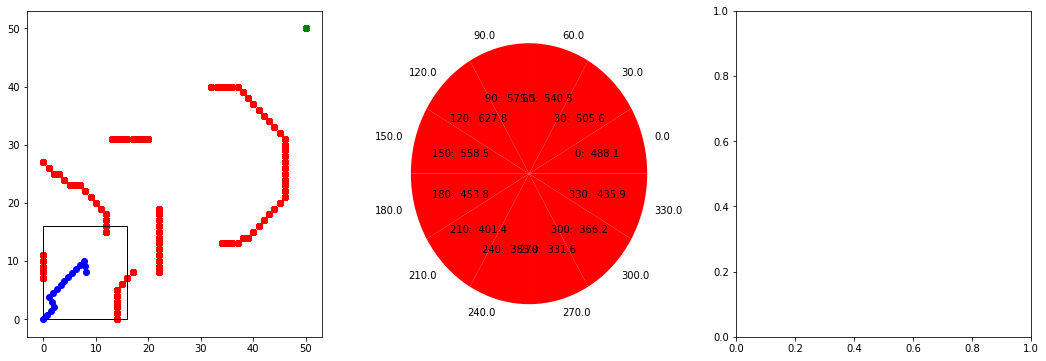

index, angle, certainty
0 0.0 488.13548949749423
1 30.0 505.6138982576127
2 60.0 540.5411926769767
3 90.0 575.4684870963407
4 120.0 627.8446671749502
5 150.0 558.4572002873672
6 180.0 453.7892215720806
7 210.0 401.4073816981711
8 240.0 383.9289729380527
9 270.0 331.5527928594431
10 300.0 366.2015056846185
11 330.0 435.94218998054106

robot: step: best angle = 285.0
robot: discrete_location = (8.0, 7.0)
path_planner: generate_histogram: robot_location = (8.0, 7.0)
path_planner: generate_histogram: active_region = (0, 0, 16, 15)


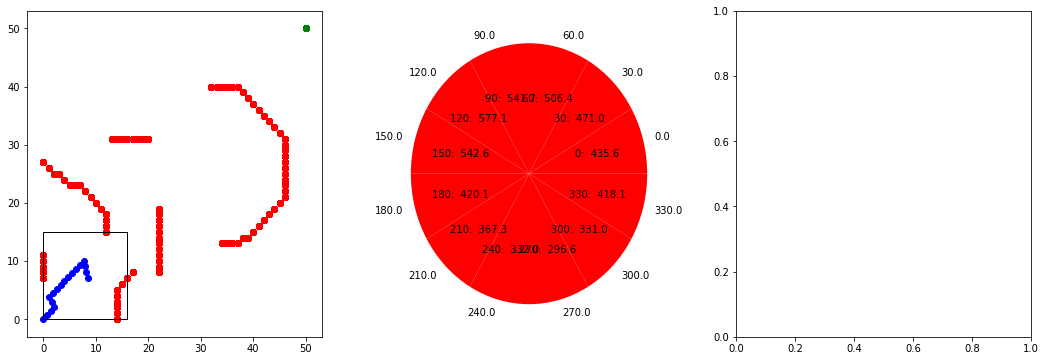

index, angle, certainty
0 0.0 435.6442584838393
1 30.0 471.0048711685468
2 60.0 506.36548385325426
3 90.0 541.7260965379618
4 120.0 577.0867092226694
5 150.0 542.5978320402752
6 180.0 420.12783250600864
7 210.0 367.3126743667557
8 240.0 331.95206168204817
9 270.0 296.5914489973406
10 300.0 330.98300194369074
11 330.0 418.0923887932498

robot: step: best angle = 285.0
robot: discrete_location = (8.0, 6.0)
path_planner: generate_histogram: robot_location = (8.0, 6.0)
path_planner: generate_histogram: active_region = (0, 0, 16, 14)


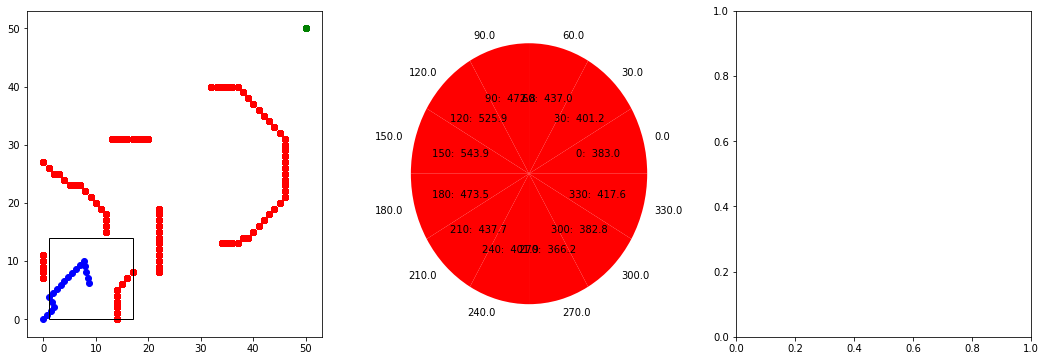

index, angle, certainty
0 0.0 383.0004040348504
1 30.0 401.2375467987322
2 60.0 437.02014410806856
3 90.0 472.80274141740483
4 120.0 525.9095222601906
5 150.0 543.854168789094
6 180.0 473.50763917565325
7 210.0 437.72504186631704
8 240.0 401.9424445569806
9 270.0 366.15984724764434
10 300.0 382.7857377927559
11 330.0 417.57094110886555

robot: step: best angle = 285.0
robot: discrete_location = (8.0, 5.0)
path_planner: generate_histogram: robot_location = (8.0, 5.0)
path_planner: generate_histogram: active_region = (0, 0, 16, 13)


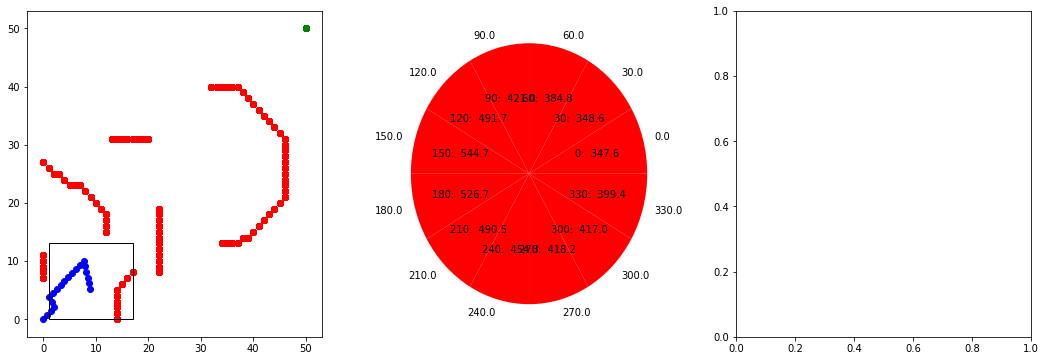

index, angle, certainty
0 0.0 347.6126142500716
1 30.0 348.61548643449333
2 60.0 384.79371609056375
3 90.0 420.9719457466341
4 120.0 491.74708620888117
5 150.0 544.7320646299569
6 180.0 526.6985941814157
7 210.0 490.52036452534554
8 240.0 454.3421348692751
9 270.0 418.16390521320477
10 300.0 416.983734445604
11 330.0 399.4174219035467

robot: step: best angle = 15.0
robot: discrete_location = (9.0, 5.0)
path_planner: generate_histogram: robot_location = (9.0, 5.0)
path_planner: generate_histogram: active_region = (1, 0, 17, 13)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:108: UserWarning: path_planner: the entire polar histogram is above valley threshold = 200, setting best angle to least likely bin middle angle = 15.0
  warnings.warn("path_planner: the entire polar histogram is above valley threshold = %s, setting best angle to least likely bin middle angle = %s" % (self.valley_threshold, middle_angle))


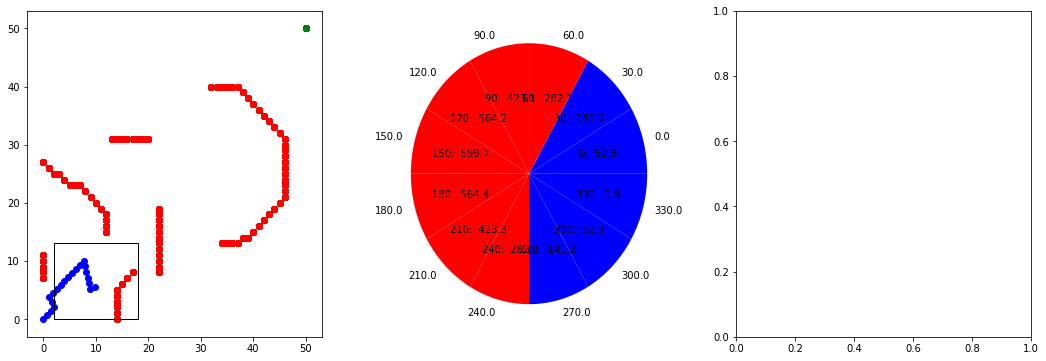

index, angle, certainty
0 0.0 52.7904414596233
1 30.0 140.9914116173623
2 60.0 282.0684842824123
3 90.0 423.14555694746235
4 120.0 564.2226296125124
5 150.0 599.7188193583158
6 180.0 564.3939517078878
7 210.0 423.31687904283785
8 240.0 282.2398063777878
9 270.0 141.16273371273775
10 300.0 52.876102507311025
11 330.0 0.0

robot: step: best angle = 30.0
robot: discrete_location = (10.0, 5.0)
path_planner: generate_histogram: robot_location = (10.0, 5.0)
path_planner: generate_histogram: active_region = (2, 0, 18, 13)


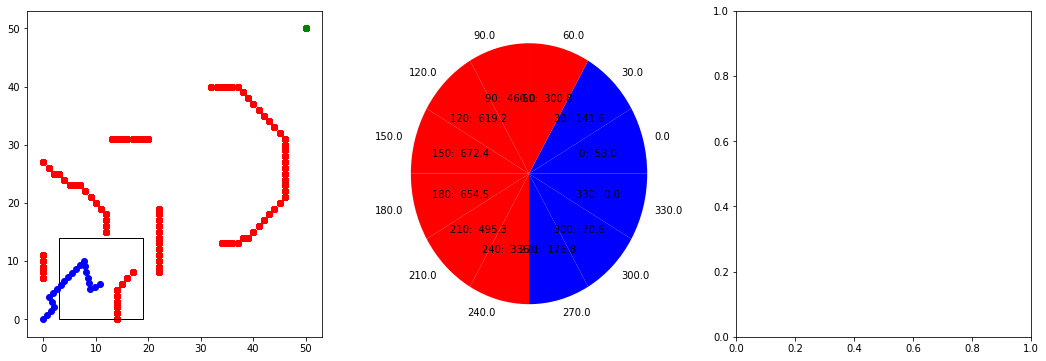

index, angle, certainty
0 0.0 52.99454741027952
1 30.0 141.57134558595746
2 60.0 300.78093031256327
3 90.0 459.9905150391691
4 120.0 619.2000997657749
5 150.0 672.4205896718217
6 180.0 654.4765780470716
7 210.0 495.2669933204659
8 240.0 336.05740859386
9 270.0 176.84782386725416
10 300.0 70.63278655092786
11 330.0 0.0

robot: step: best angle = 30.0
robot: discrete_location = (11.0, 6.0)
path_planner: generate_histogram: robot_location = (11.0, 6.0)
path_planner: generate_histogram: active_region = (3, 0, 19, 14)


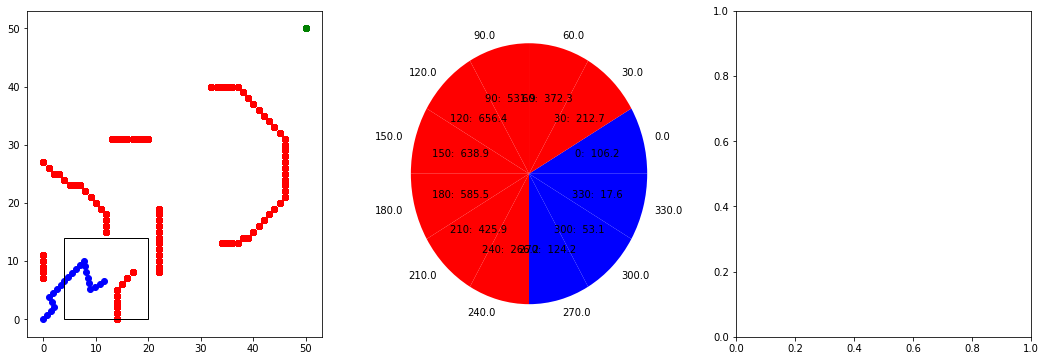

index, angle, certainty
0 0.0 106.17313166159751
1 30.0 212.6686202570433
2 60.0 372.30742023122275
3 90.0 531.9462202054023
4 120.0 656.4410572582179
5 150.0 638.877556830566
6 180.0 585.5253796138539
7 210.0 425.88657963967455
8 240.0 266.24777966549505
9 270.0 124.1809611519975
10 300.0 53.14331137873367
11 330.0 17.571981460681876

robot: step: best angle = 15.0
robot: discrete_location = (12.0, 6.0)
path_planner: generate_histogram: robot_location = (12.0, 6.0)
path_planner: generate_histogram: active_region = (4, 0, 20, 14)


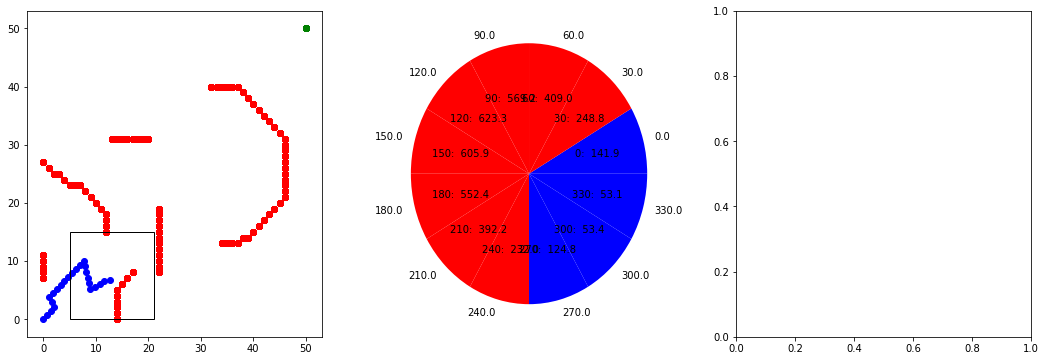

index, angle, certainty
0 0.0 141.92748267589528
1 30.0 248.75912790678794
2 60.0 408.9991121892486
3 90.0 569.2390964717091
4 120.0 623.3303273146191
5 150.0 605.8640996848399
6 180.0 552.4407935055152
7 210.0 392.2008092230546
8 240.0 231.960824940594
9 270.0 124.79521737790873
10 300.0 53.408339051567985
11 330.0 53.07437671977538

robot: step: best angle = 15.0
robot: discrete_location = (13.0, 6.0)
path_planner: generate_histogram: robot_location = (13.0, 6.0)
path_planner: generate_histogram: active_region = (5, 0, 21, 14)


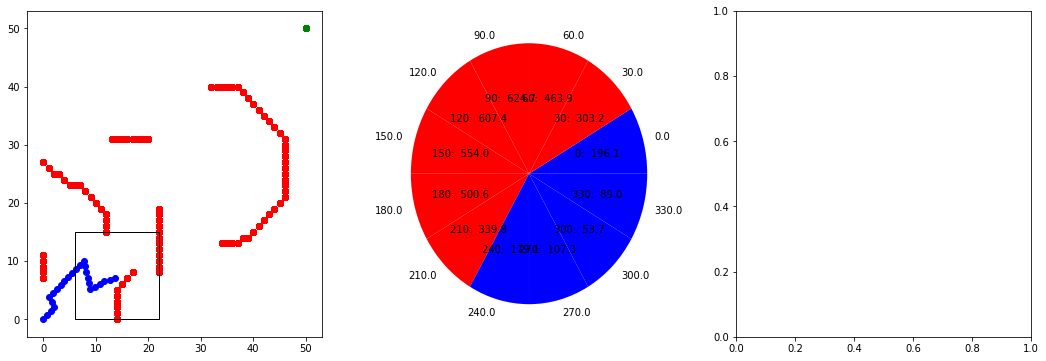

index, angle, certainty
0 0.0 196.10721089302487
1 30.0 303.187442995793
2 60.0 463.9372738608188
3 90.0 624.6871047258444
4 120.0 607.3829780103566
5 150.0 553.9723446698459
6 180.0 500.56171132933525
7 210.0 339.8118804643096
8 240.0 179.06204959928394
9 270.0 107.33919752451493
10 300.0 53.669598762257465
11 330.0 89.02697879025665

robot: step: best angle = 15.0
robot: discrete_location = (14.0, 7.0)
path_planner: generate_histogram: robot_location = (14.0, 7.0)
path_planner: generate_histogram: active_region = (6, 0, 22, 15)


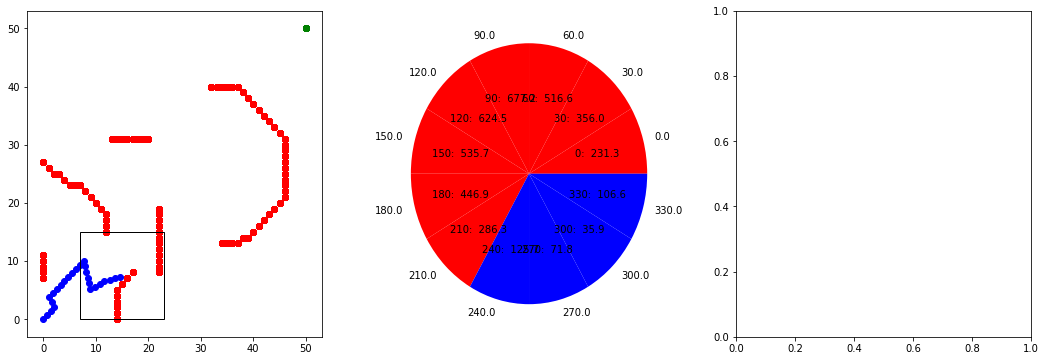

index, angle, certainty
0 0.0 231.3259805852388
1 30.0 356.01559753411397
2 60.0 516.5995528775194
3 90.0 677.1835082209246
4 120.0 624.4947362916026
5 150.0 535.6994577372577
6 180.0 446.9041791829126
7 210.0 286.3202238395073
8 240.0 125.736268496102
9 270.0 71.7886767890603
10 300.0 35.89433839453015
11 330.0 106.63636363636364

robot: step: best angle = 50.345670568906684
robot: discrete_location = (15.0, 8.0)
path_planner: generate_histogram: robot_location = (15.0, 8.0)
path_planner: generate_histogram: active_region = (7, 0, 23, 16)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:113: UserWarning: path_planner: the entire histogram is below valley_threshold = 200, setting best angle to robot_to_target_angle = 0.8786977155518283
  warnings.warn("path_planner: the entire histogram is below valley_threshold = %s, setting best angle to robot_to_target_angle = %s" % (self.valley_threshold, robot_to_target_angle))


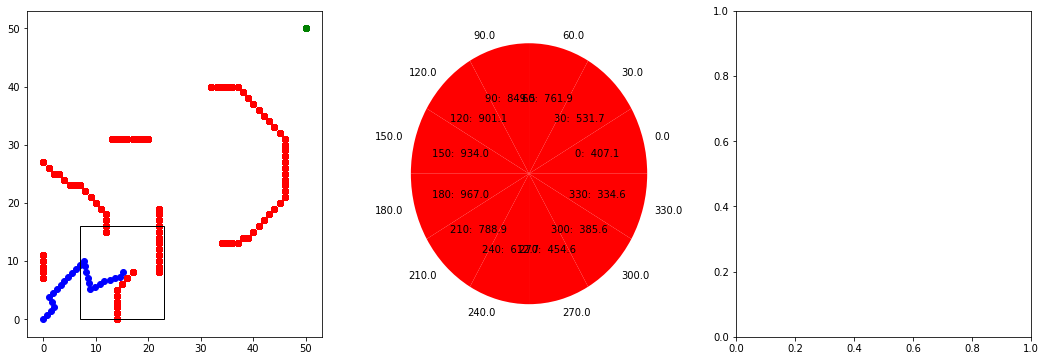

index, angle, certainty
0 0.0 407.14116068694324
1 30.0 531.741257837275
2 60.0 761.8841542098514
3 90.0 849.4692182199616
4 120.0 901.0542822300719
5 150.0 934.0223147873531
6 180.0 966.9903473446346
7 210.0 788.8727814574266
8 240.0 612.740873609496
9 270.0 454.60896576156557
10 300.0 385.5876798917727
11 330.0 334.5663940219799

robot: step: best angle = 345.0
robot: discrete_location = (16.0, 7.0)
path_planner: generate_histogram: robot_location = (16.0, 7.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 15)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:108: UserWarning: path_planner: the entire polar histogram is above valley threshold = 200, setting best angle to least likely bin middle angle = 345.0
  warnings.warn("path_planner: the entire polar histogram is above valley threshold = %s, setting best angle to least likely bin middle angle = %s" % (self.valley_threshold, middle_angle))


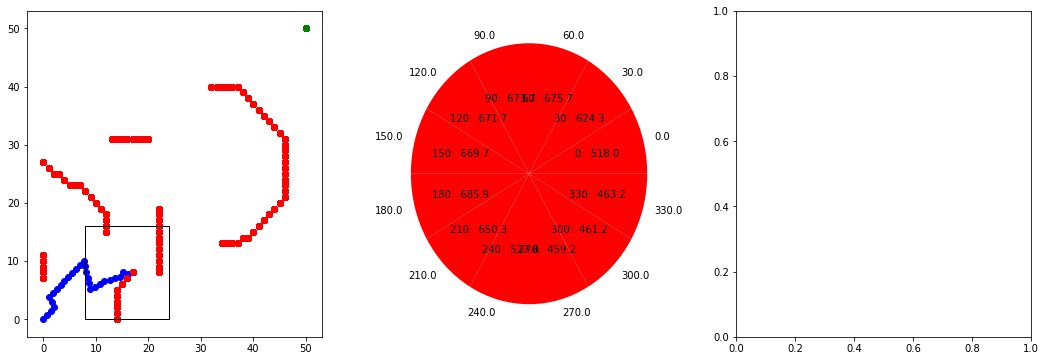

index, angle, certainty
0 0.0 518.0201212940375
1 30.0 624.2646523909162
2 60.0 675.6528982279796
3 90.0 673.6578295489306
4 120.0 671.6627608698817
5 150.0 669.6676921908327
6 180.0 685.8544416936019
7 210.0 650.2578140694333
8 240.0 527.8265334697854
9 270.0 459.22723541899376
10 300.0 461.22230409804274
11 330.0 463.21737277709167

robot: step: best angle = 285.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


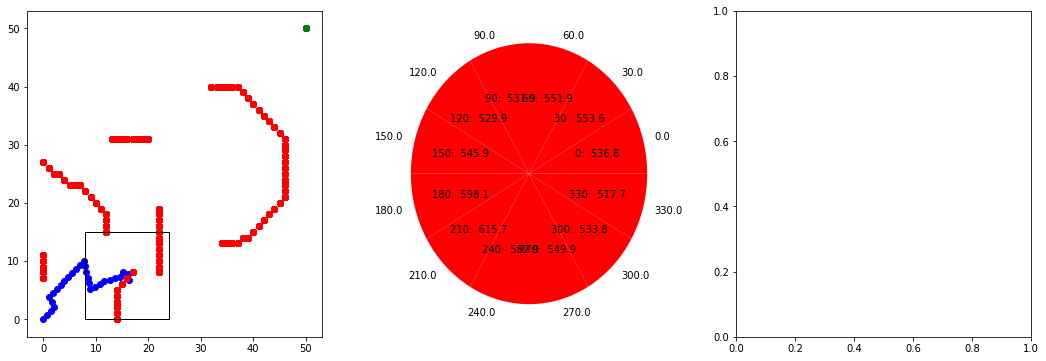

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


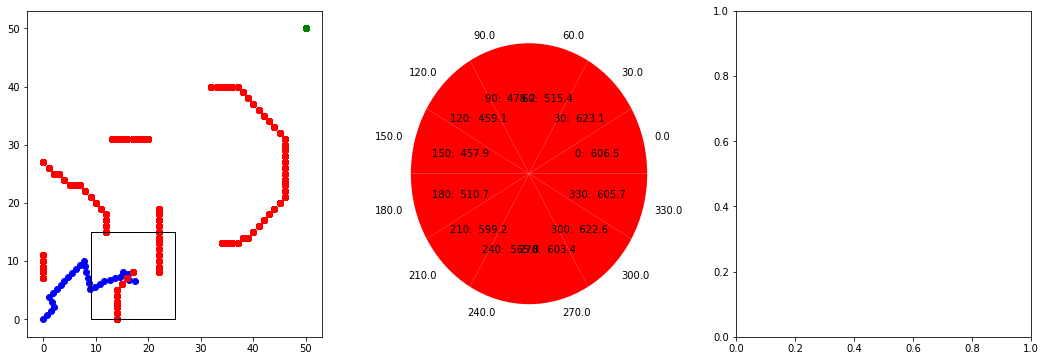

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


/Users/zhanwenchen/Documents/projects/vfh_python/lib/path_planner.py:108: UserWarning: path_planner: the entire polar histogram is above valley threshold = 200, setting best angle to least likely bin middle angle = 165.0
  warnings.warn("path_planner: the entire polar histogram is above valley threshold = %s, setting best angle to least likely bin middle angle = %s" % (self.valley_threshold, middle_angle))


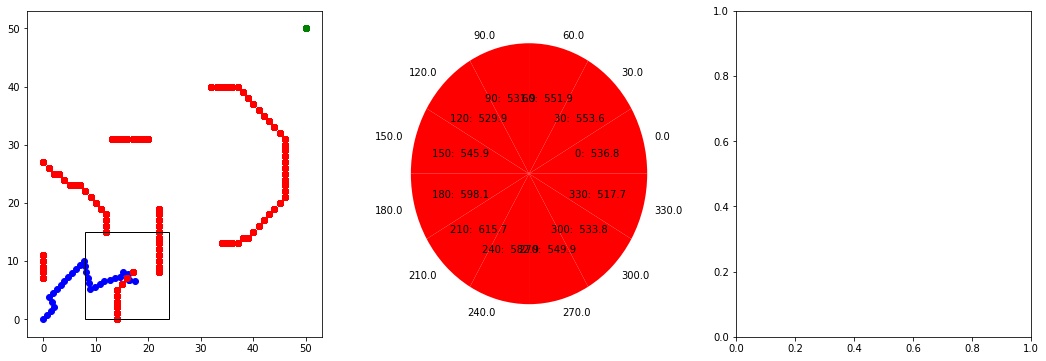

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


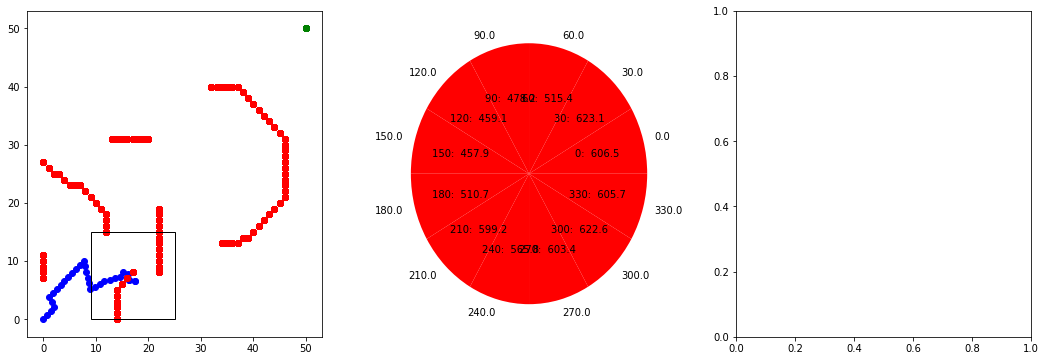

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


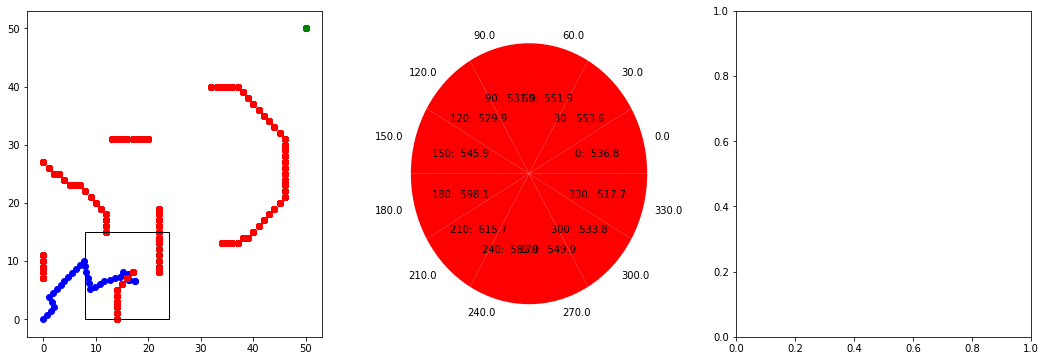

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


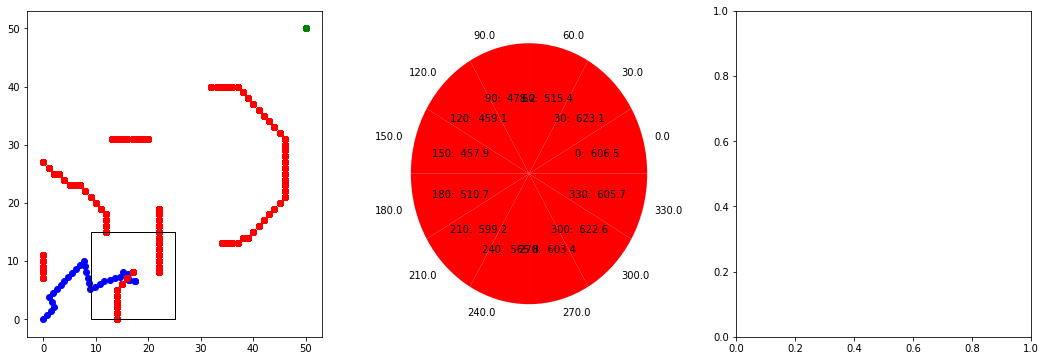

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


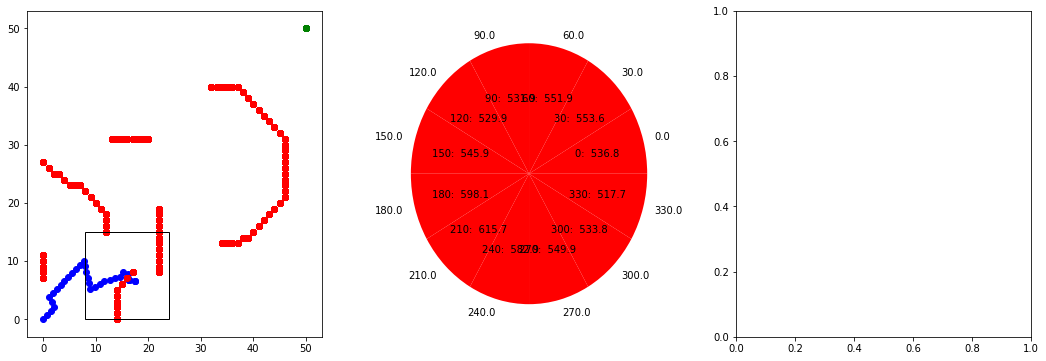

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


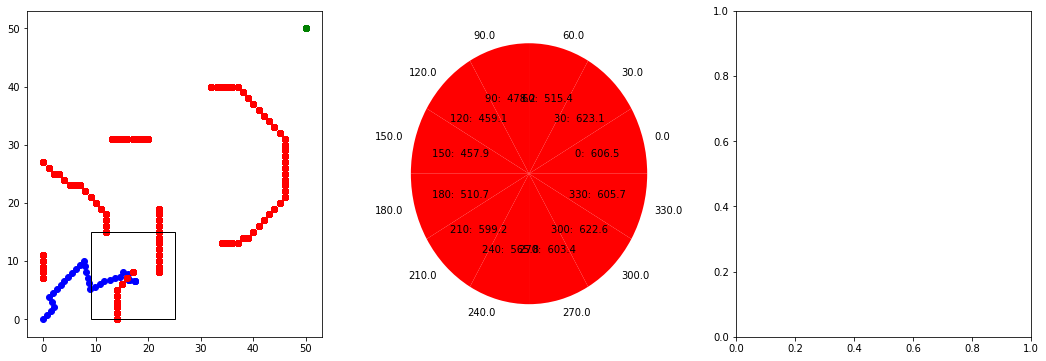

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


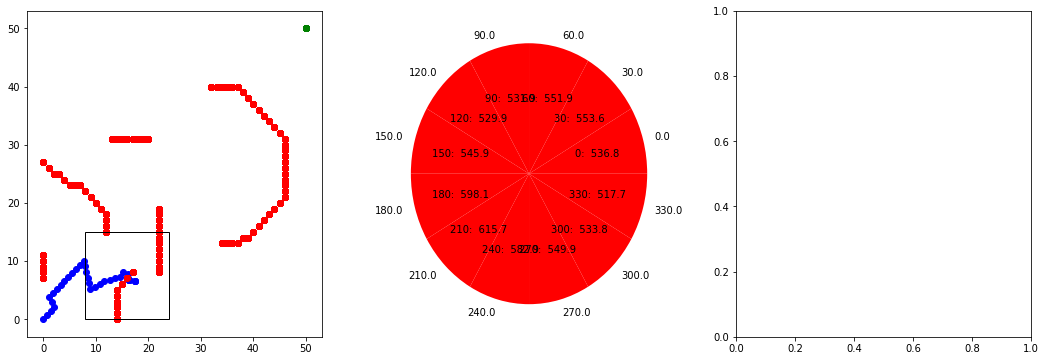

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


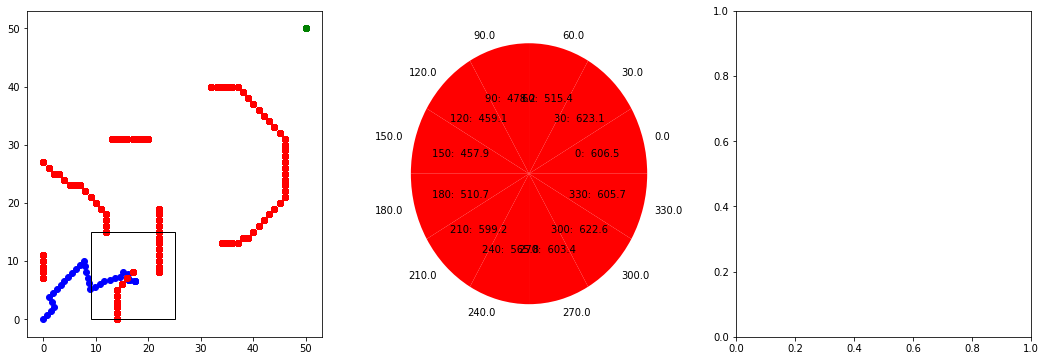

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


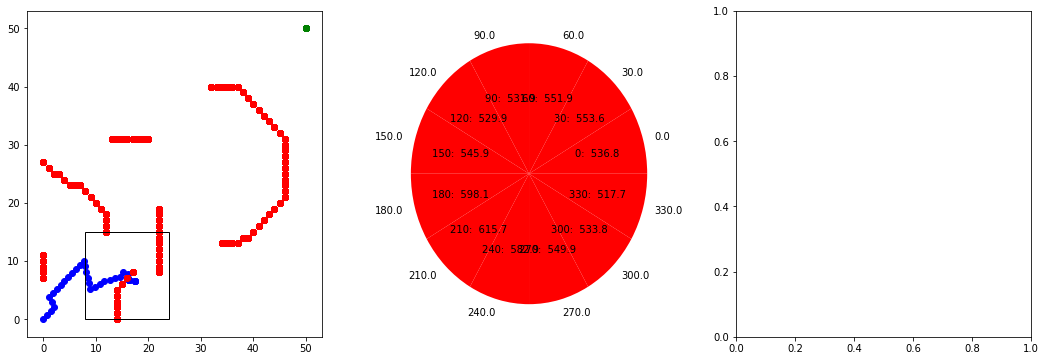

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


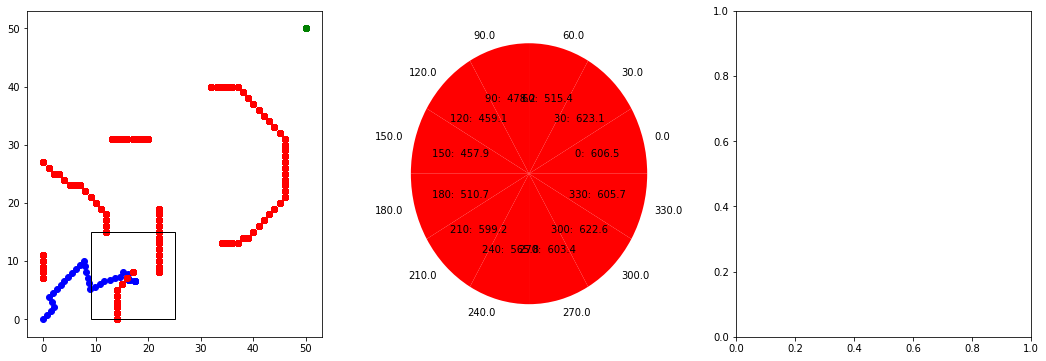

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


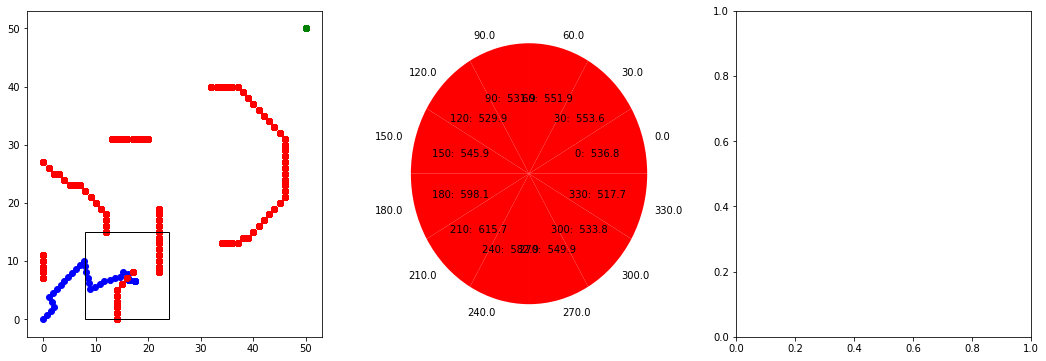

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


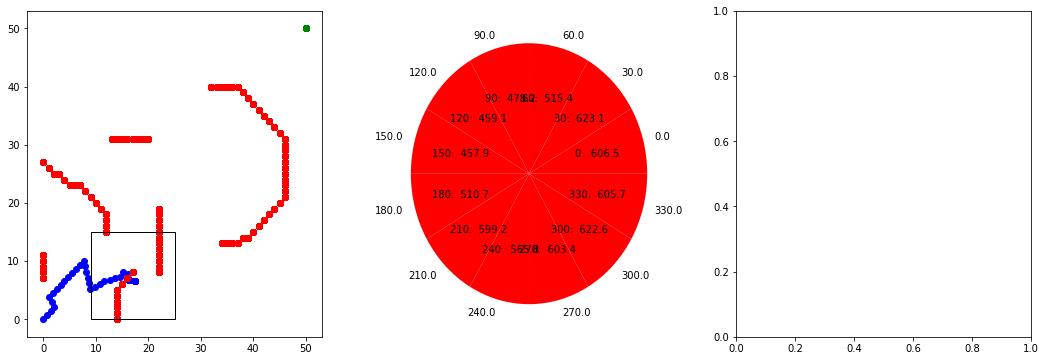

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


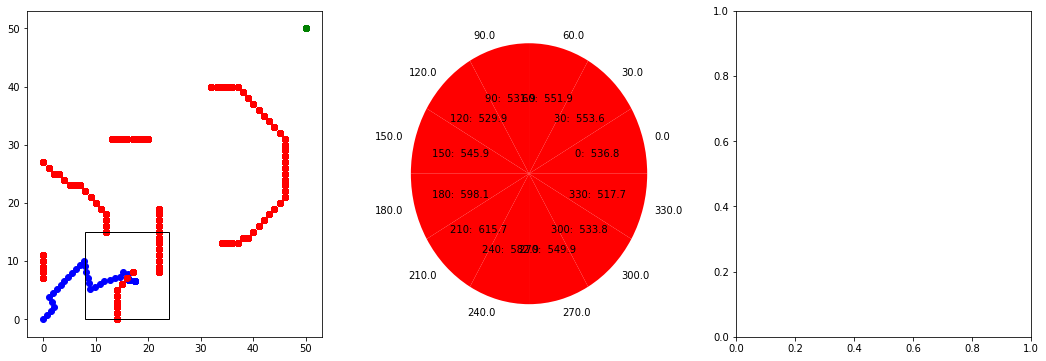

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


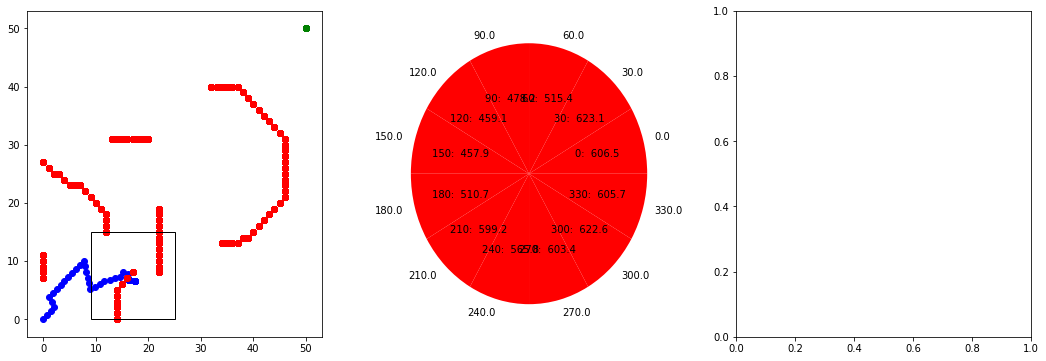

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


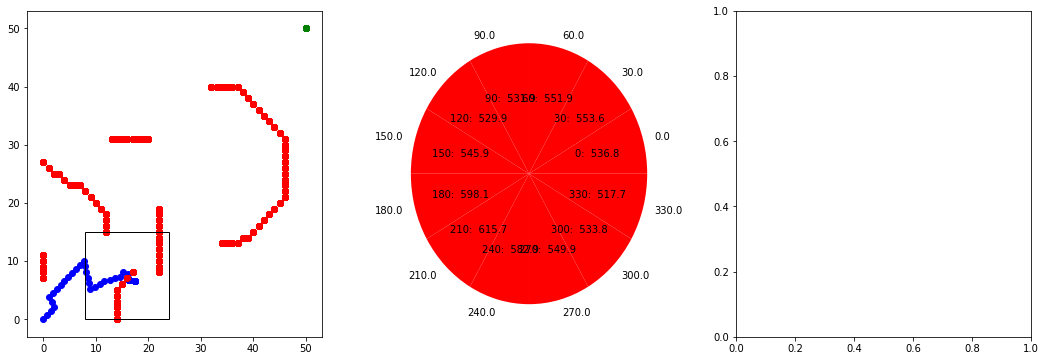

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


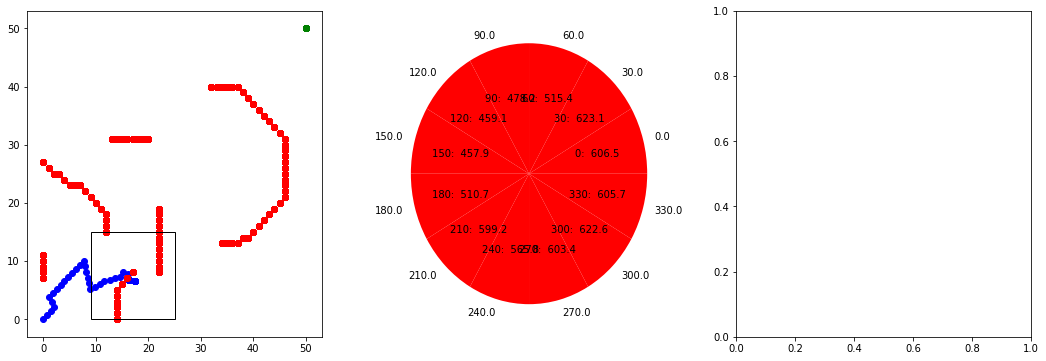

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


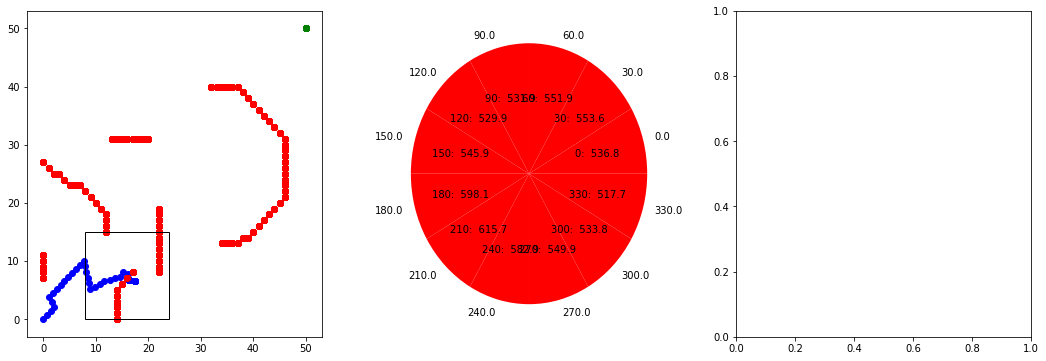

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


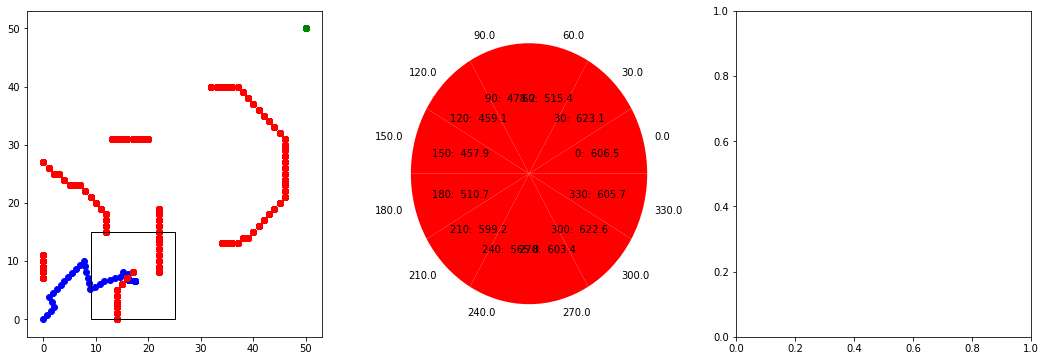

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


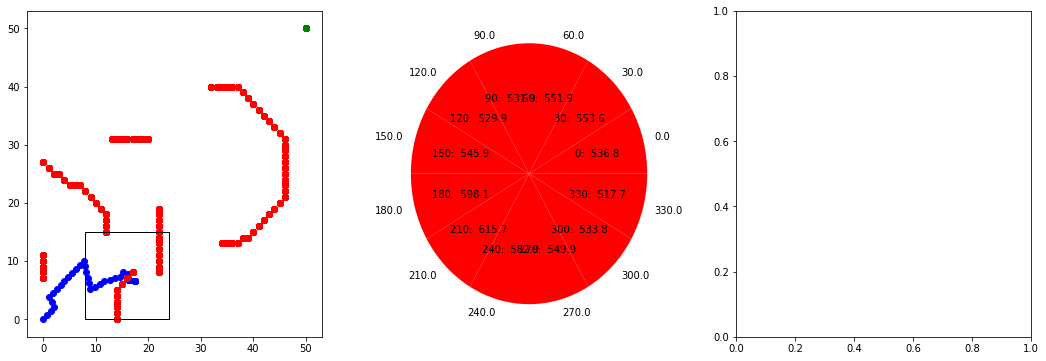

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


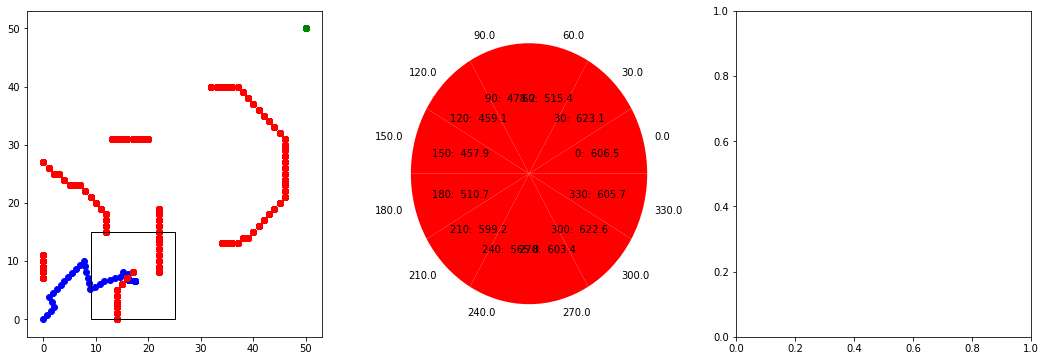

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


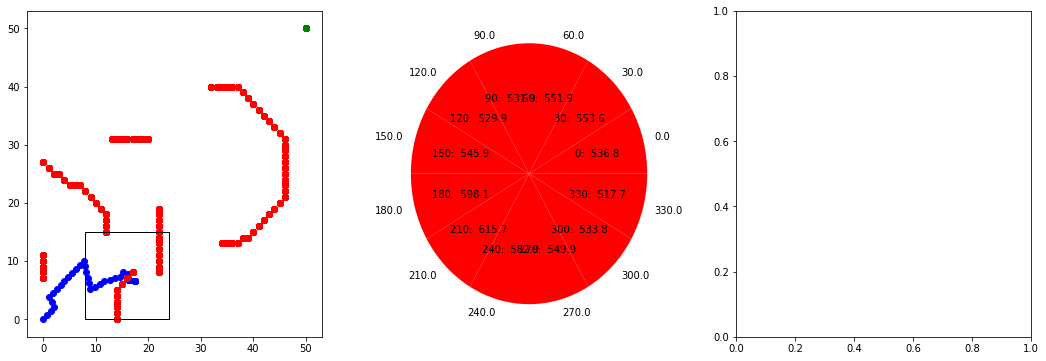

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


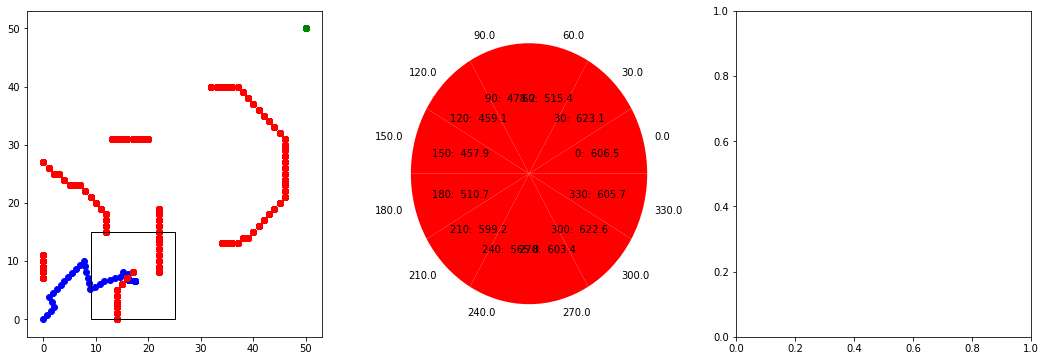

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


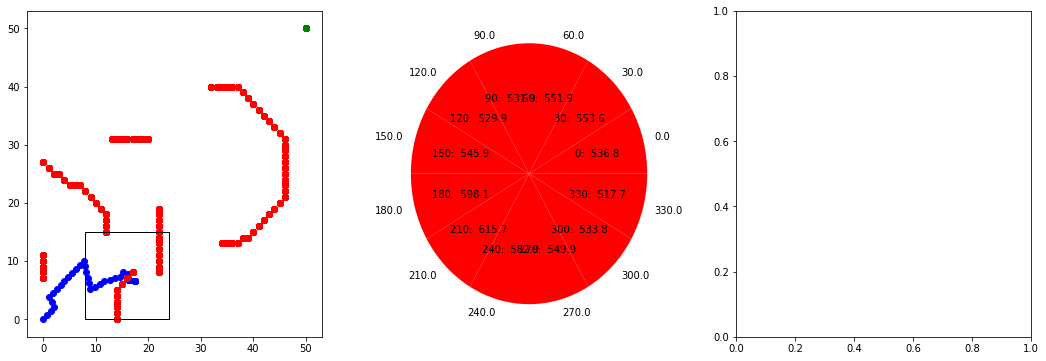

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


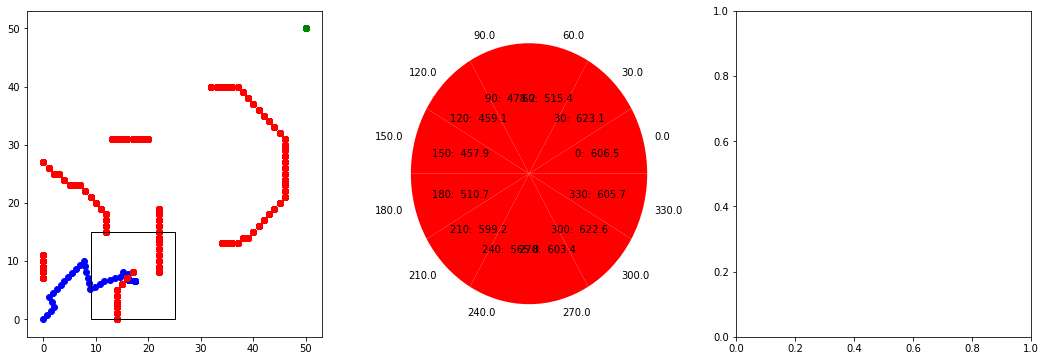

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


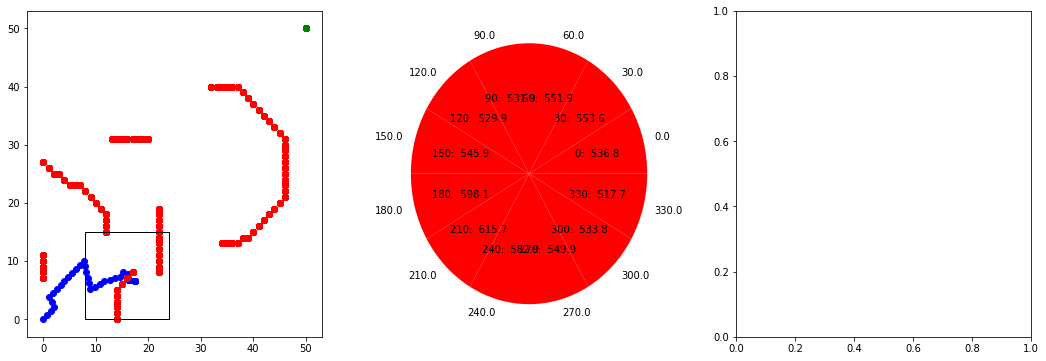

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


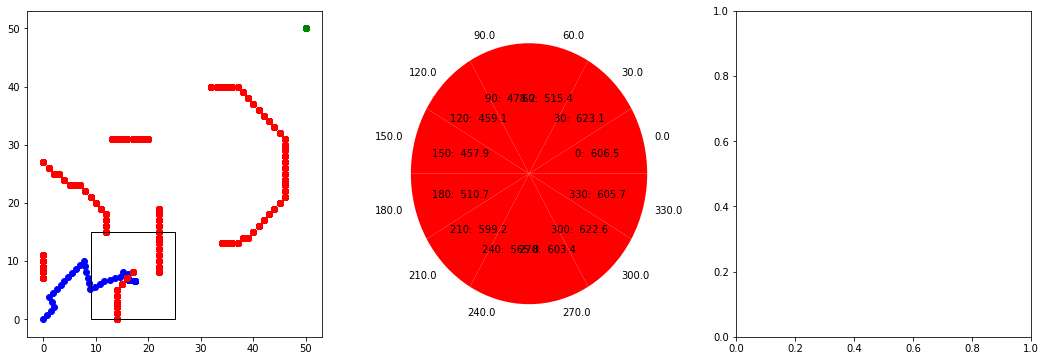

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


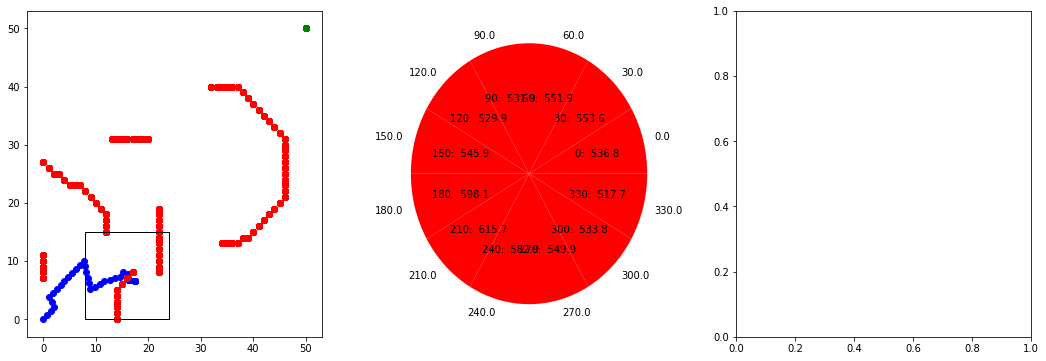

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


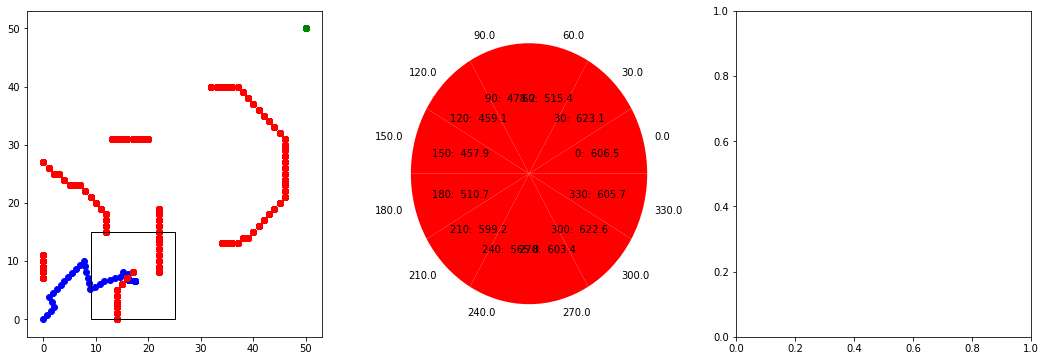

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


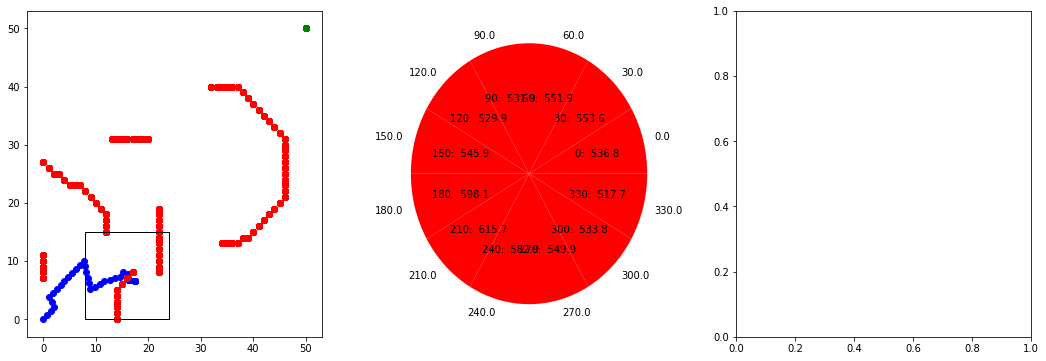

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


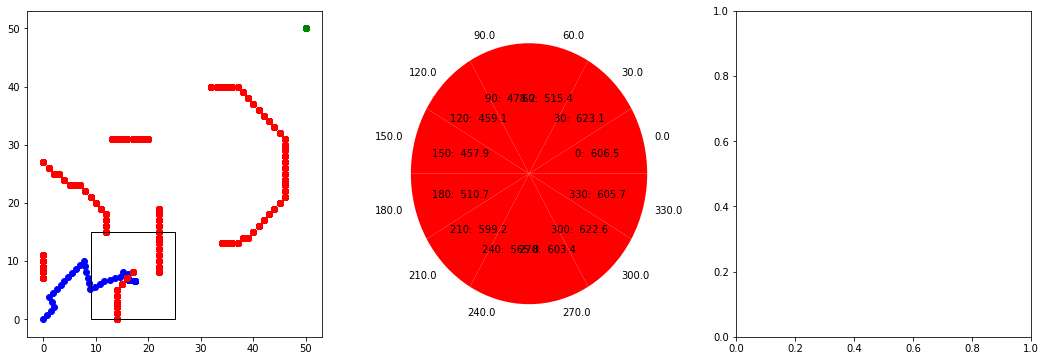

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


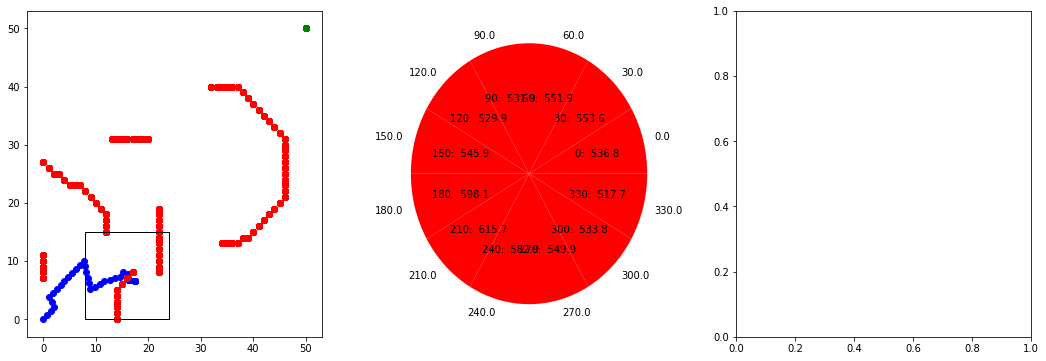

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


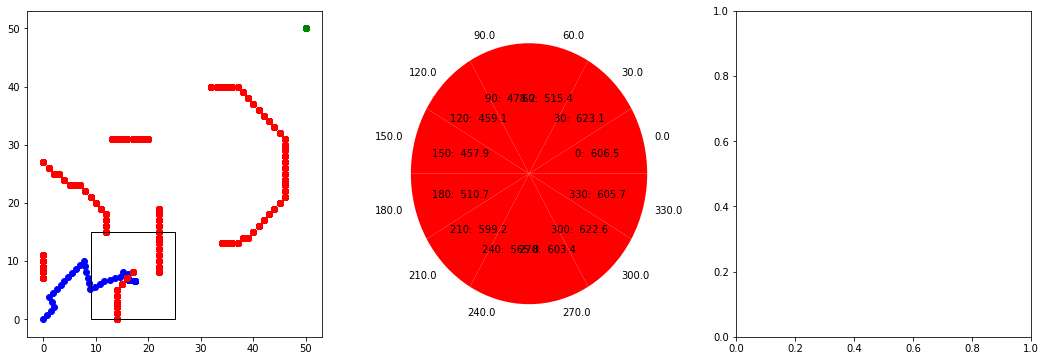

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


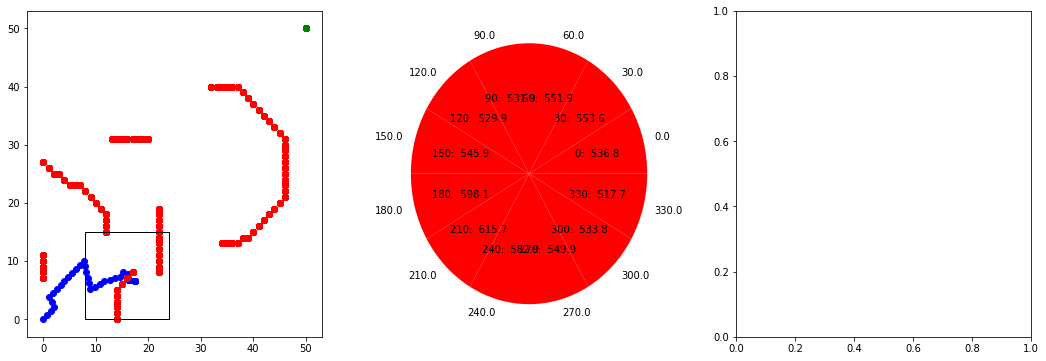

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


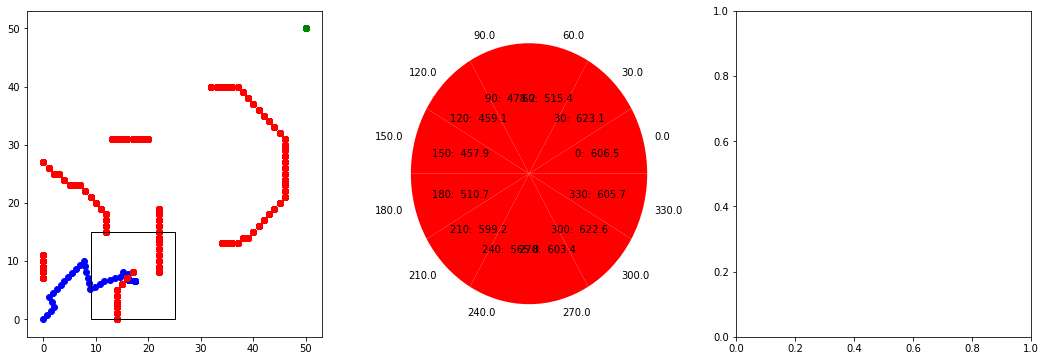

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


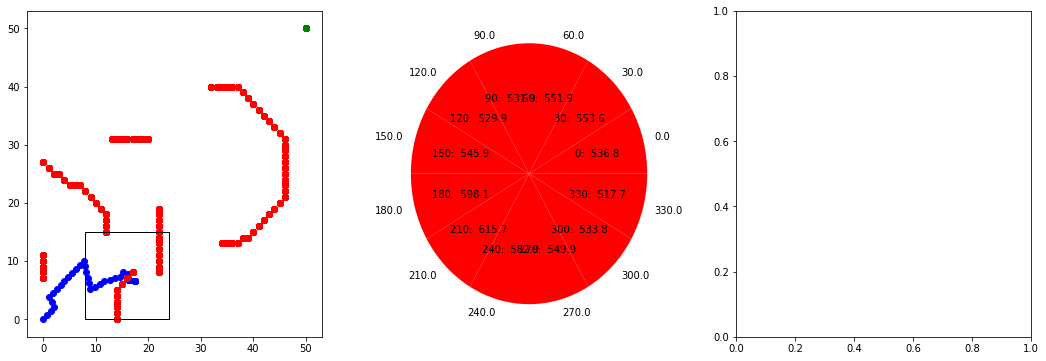

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


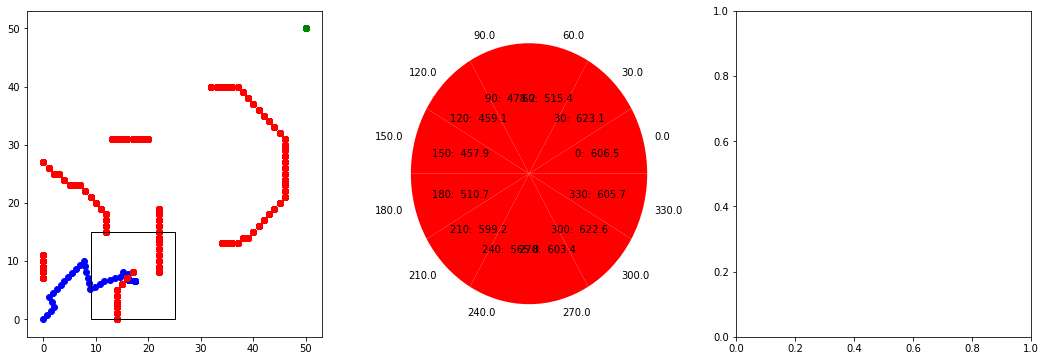

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


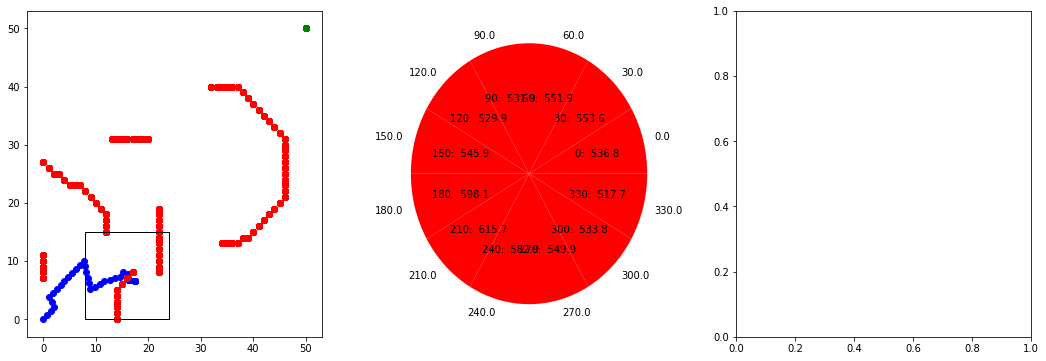

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


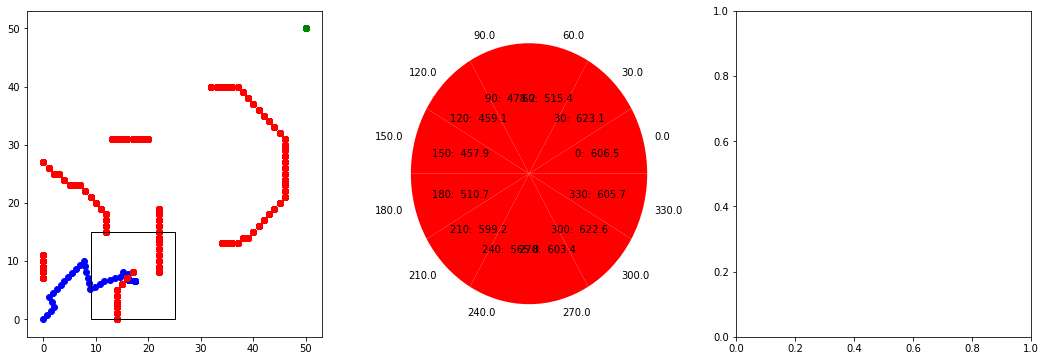

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


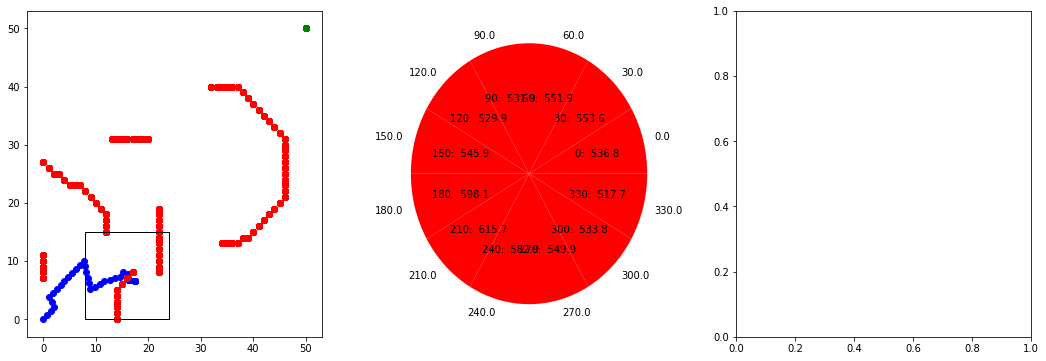

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


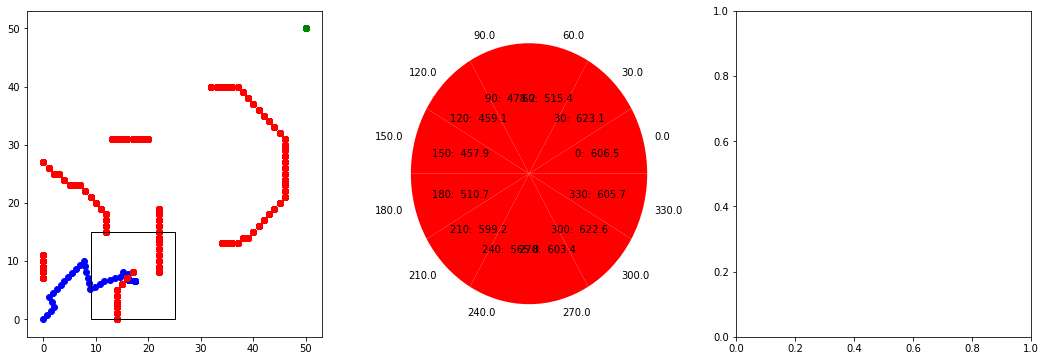

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


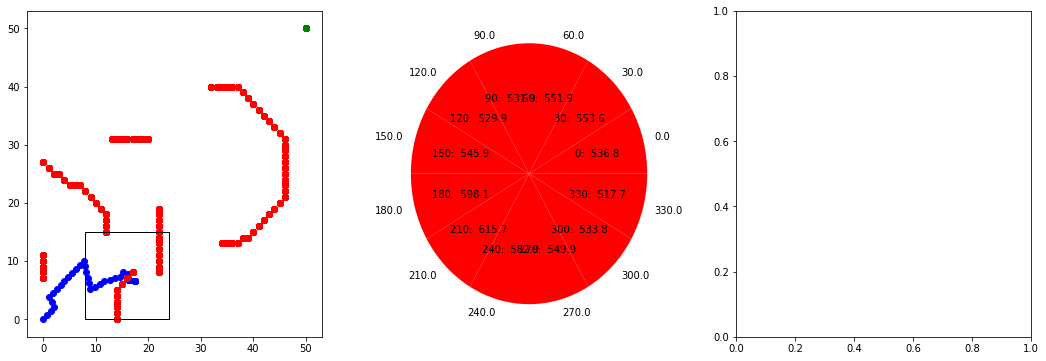

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


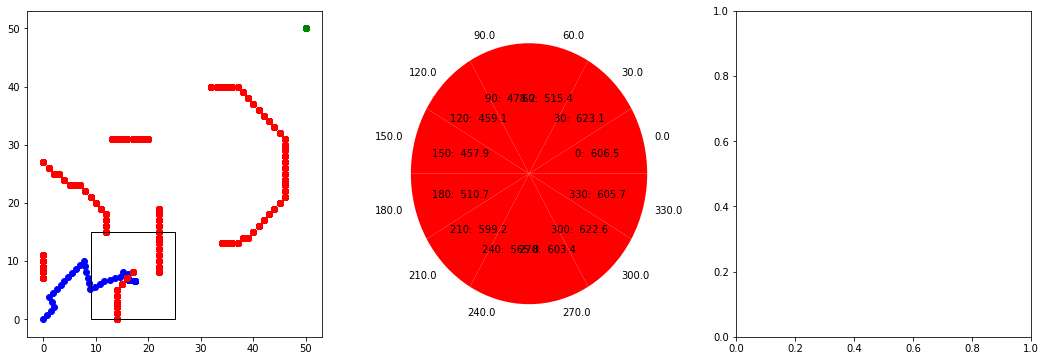

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


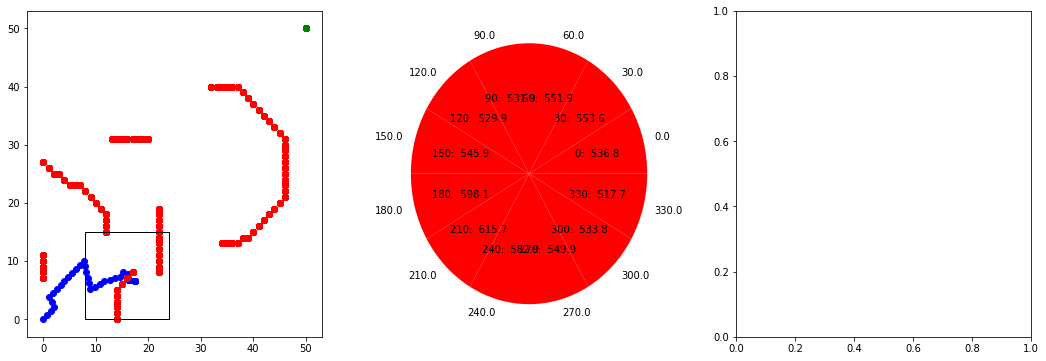

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


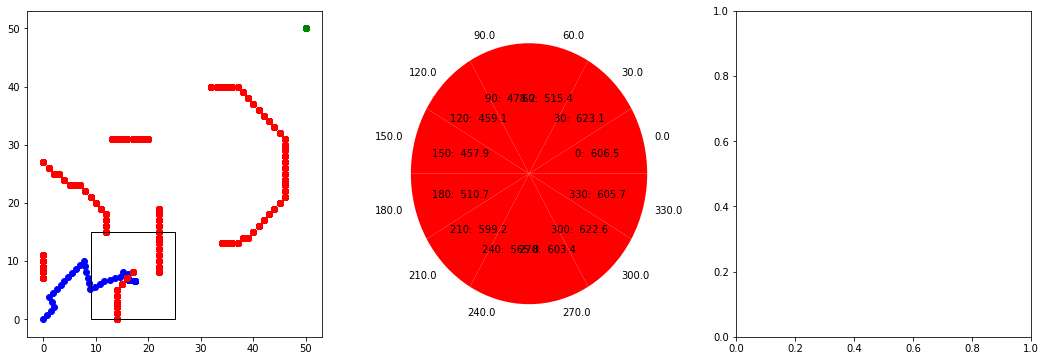

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


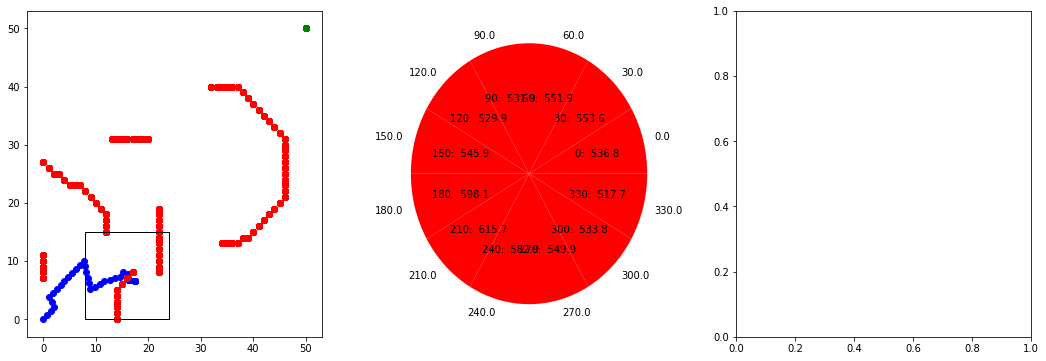

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


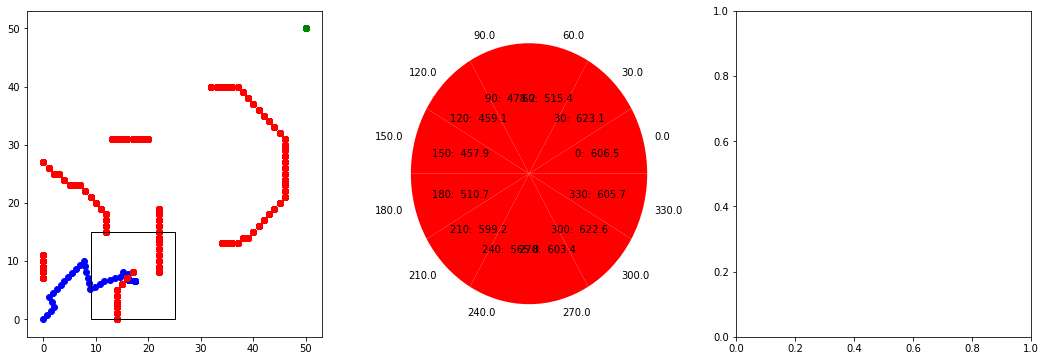

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


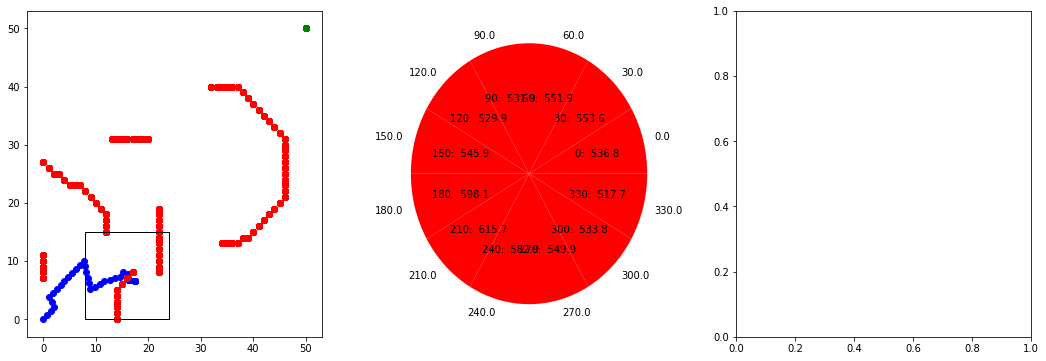

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


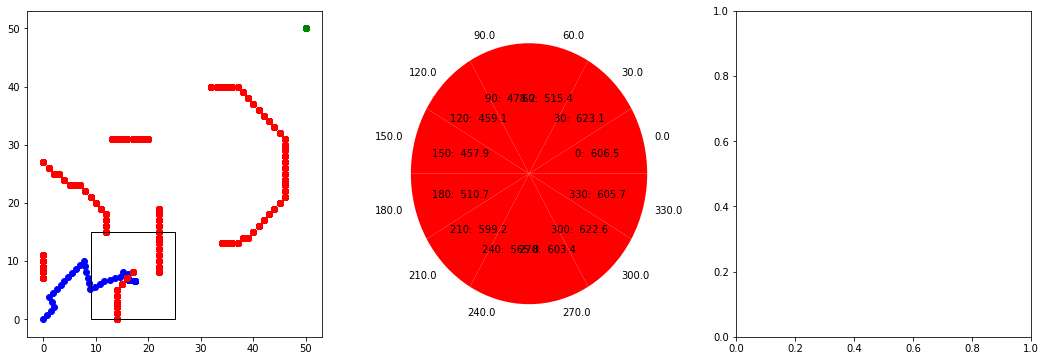

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


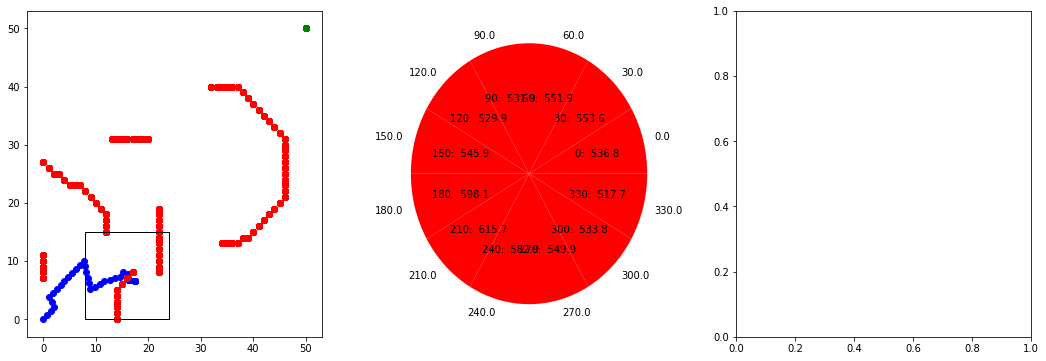

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


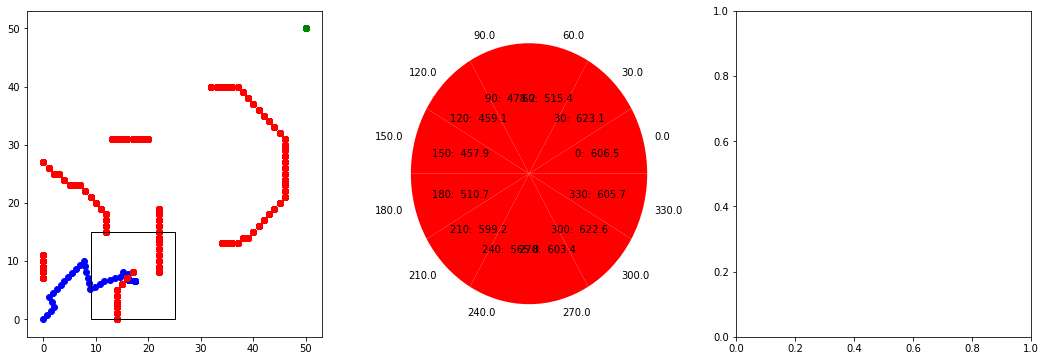

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


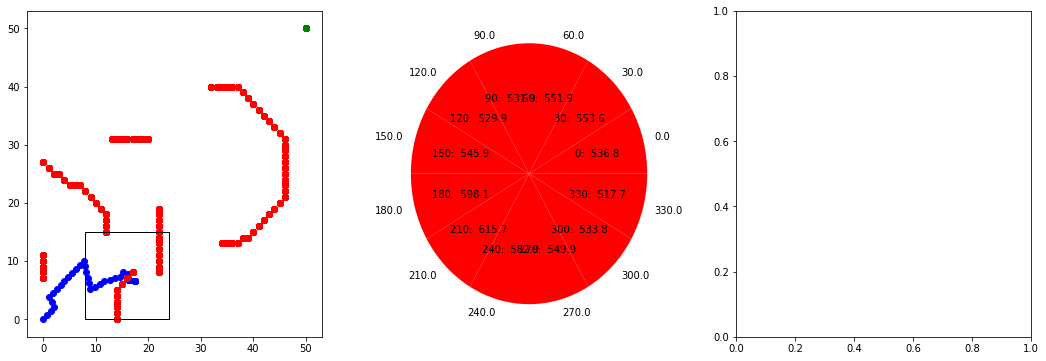

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


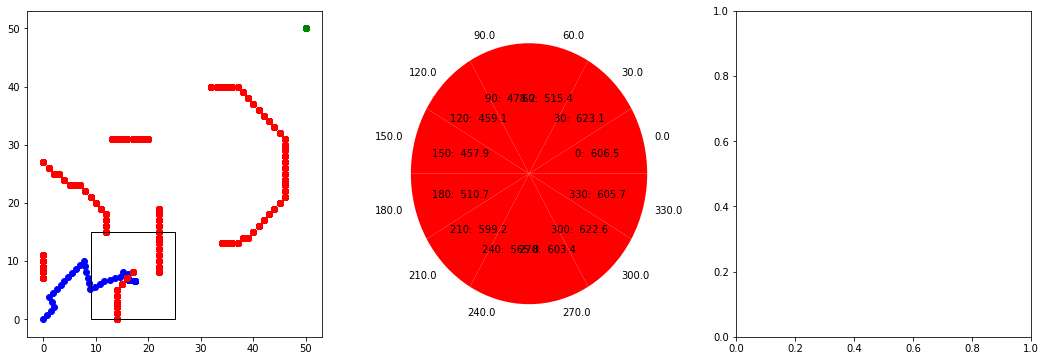

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


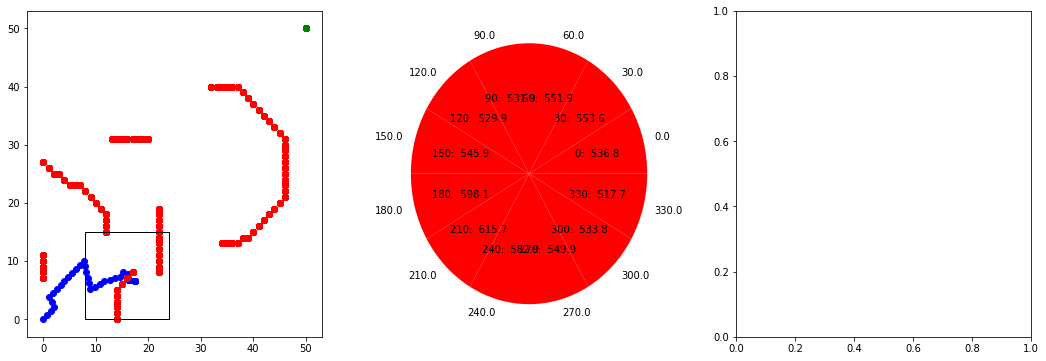

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


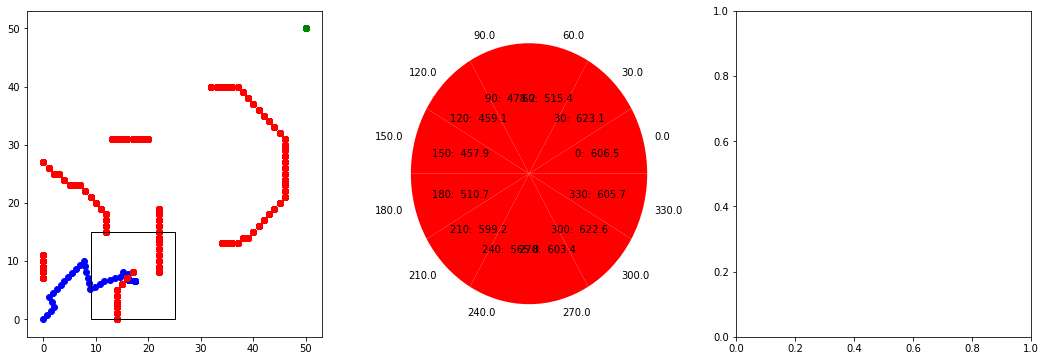

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


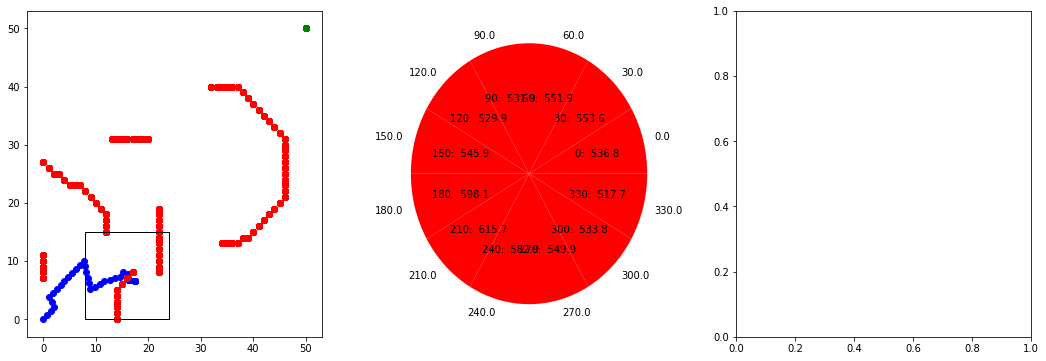

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


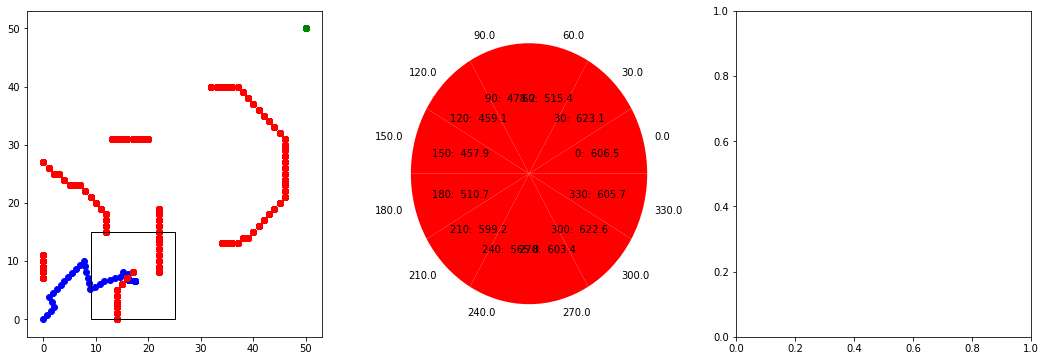

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


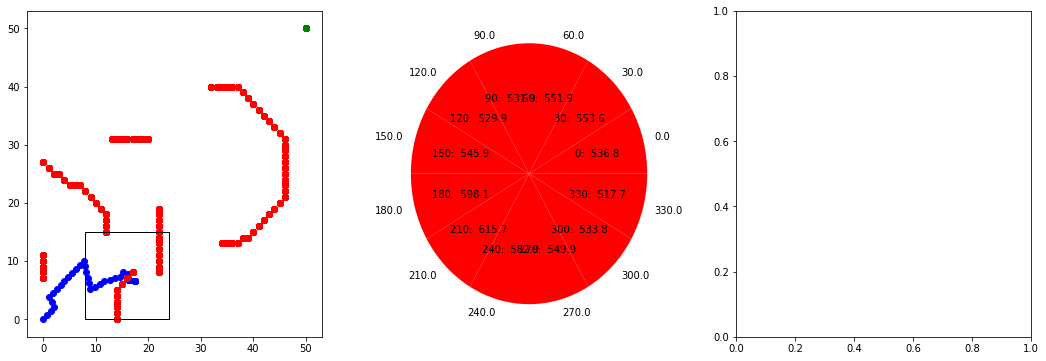

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


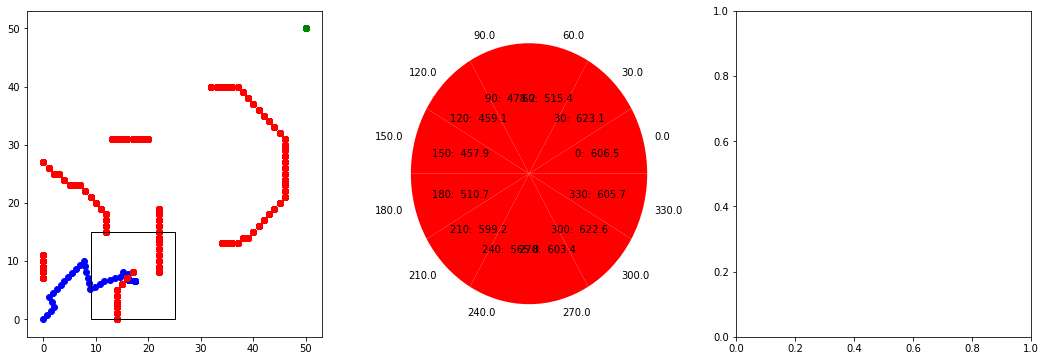

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


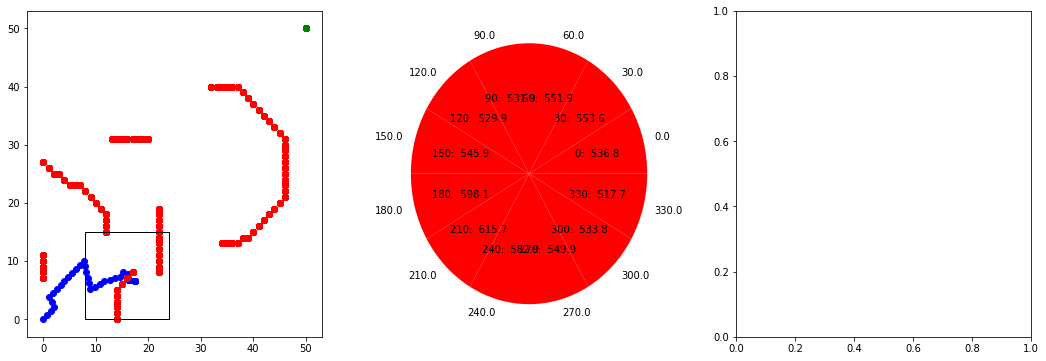

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


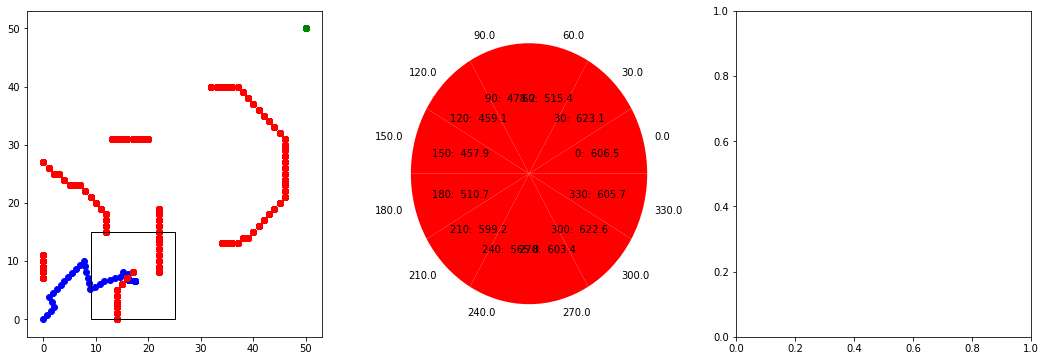

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


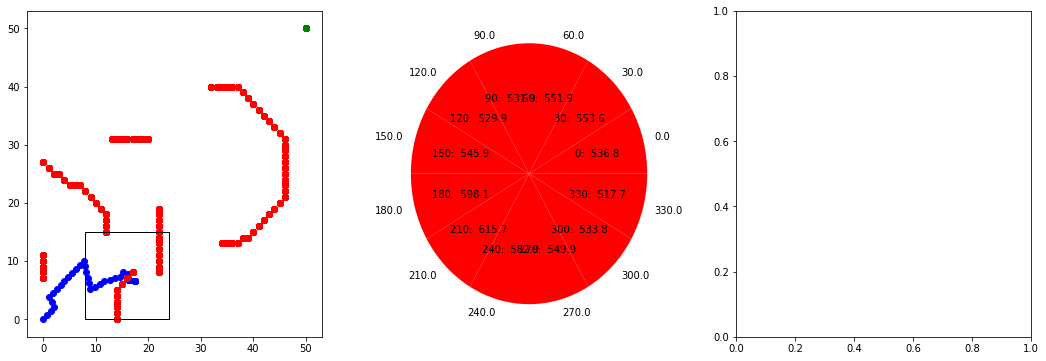

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


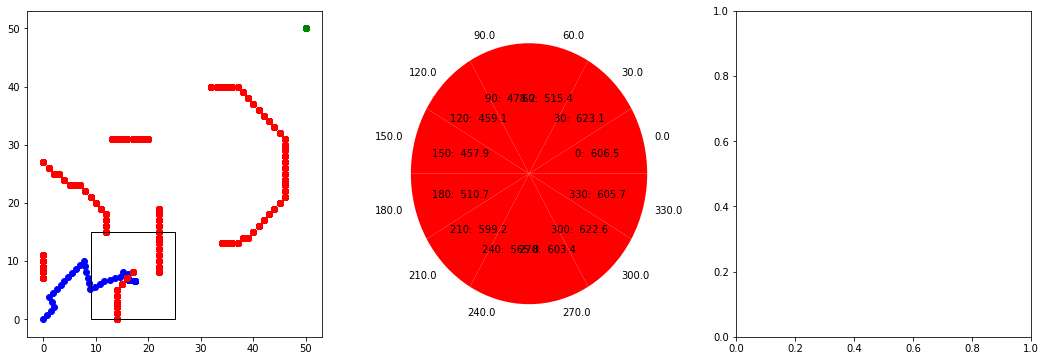

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


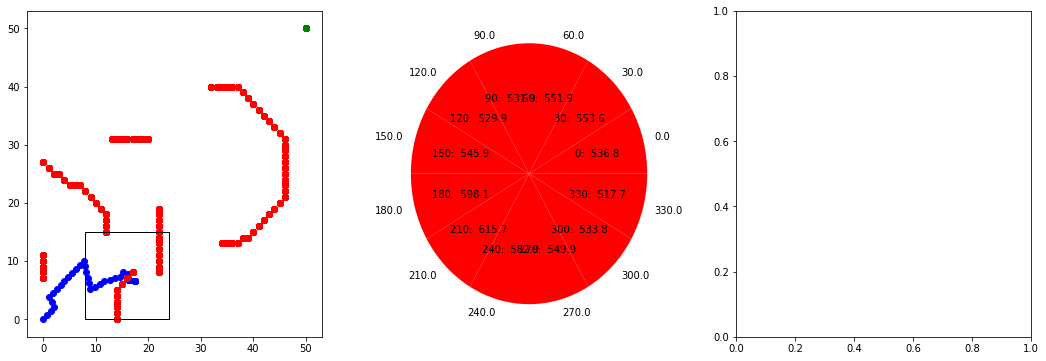

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


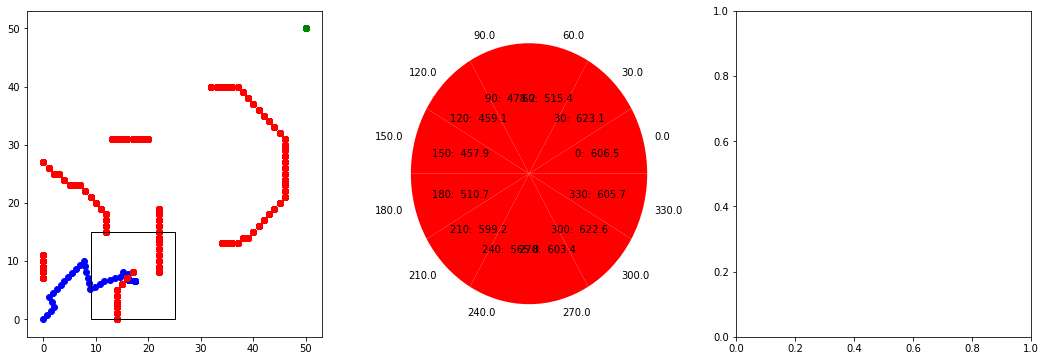

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


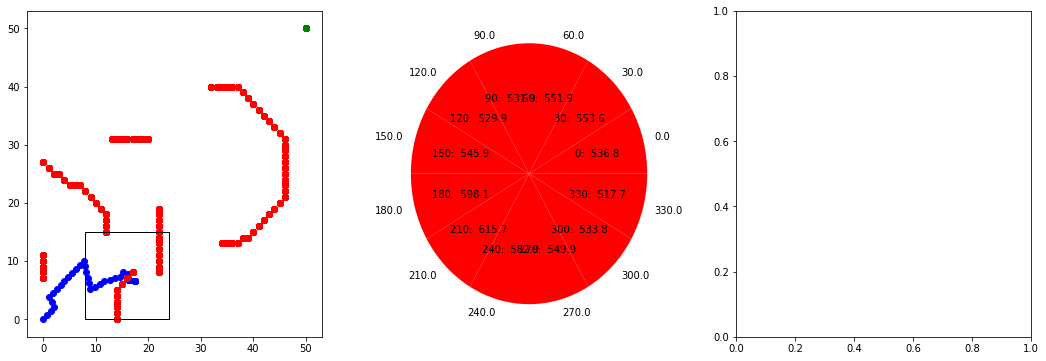

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


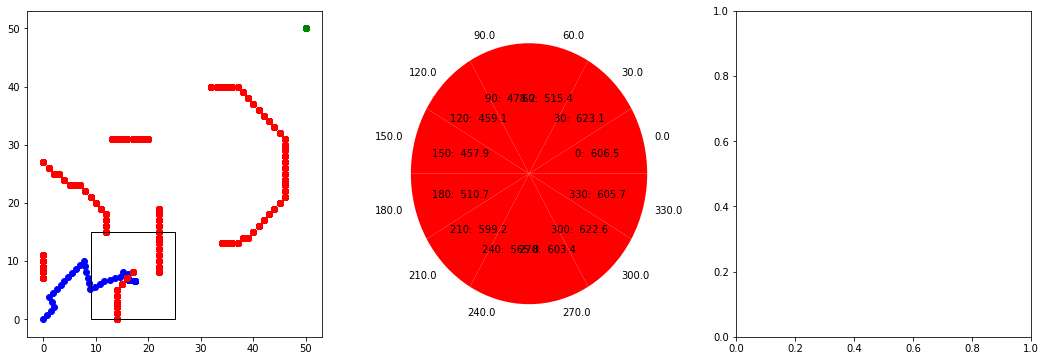

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


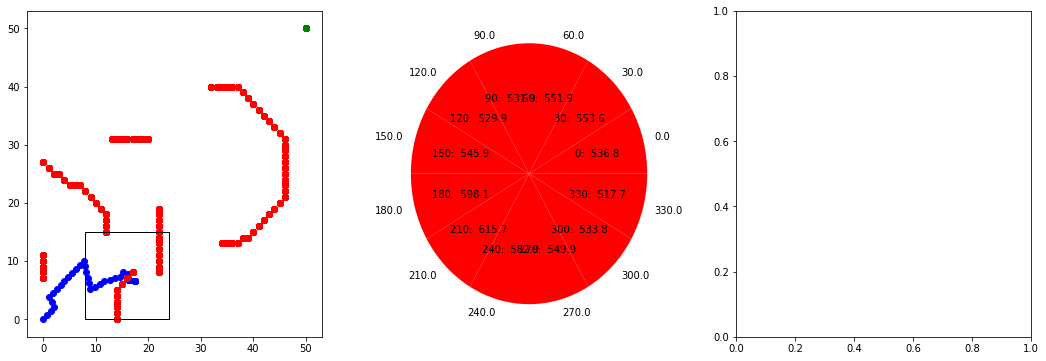

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


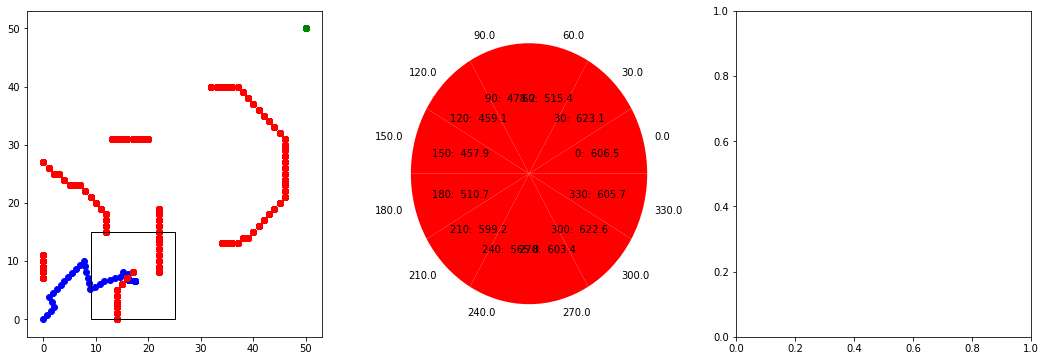

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


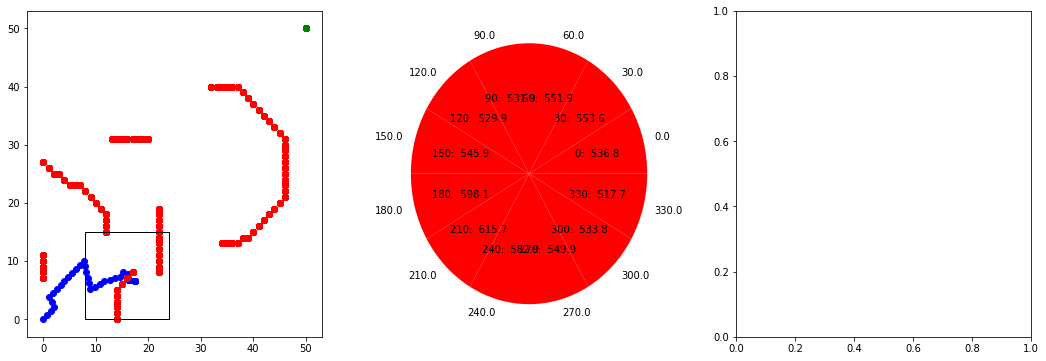

index, angle, certainty
0 0.0 536.8456463897044
1 30.0 553.5598556144606
2 60.0 551.8739857092244
3 90.0 531.8824370864044
4 120.0 529.869427738357
5 150.0 545.9473274812187
6 180.0 598.0946755897622
7 210.0 615.6630727988024
8 240.0 582.8709638311843
9 270.0 549.9005055503654
10 300.0 533.8226058075038
11 330.0 517.7447060646421

robot: step: best angle = 345.0
robot: discrete_location = (17.0, 6.0)
path_planner: generate_histogram: robot_location = (17.0, 6.0)
path_planner: generate_histogram: active_region = (9, 0, 25, 14)


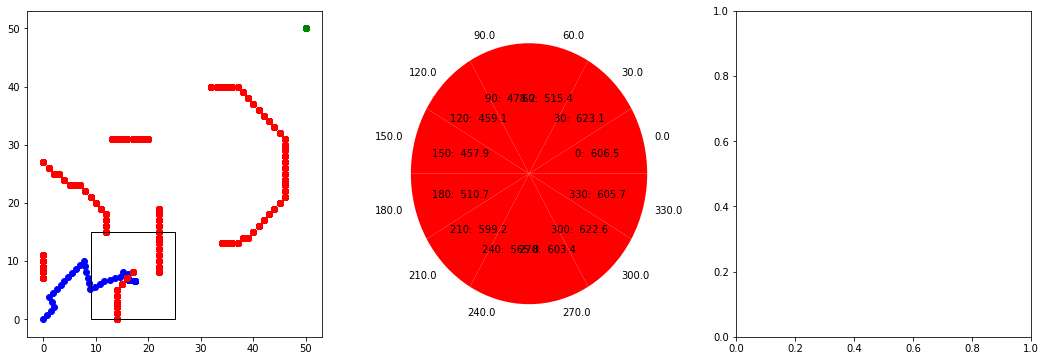

index, angle, certainty
0 0.0 606.464071253166
1 30.0 623.11762974704
2 60.0 515.4051085052524
3 90.0 478.21064989781985
4 120.0 459.0694446028989
5 150.0 457.92823930797783
6 180.0 510.7346257200985
7 210.0 599.1856653828411
8 240.0 565.778973789358
9 270.0 603.4014509361086
10 300.0 622.5959095435411
11 330.0 605.6838615259505

robot: step: best angle = 165.0
robot: discrete_location = (16.0, 6.0)
path_planner: generate_histogram: robot_location = (16.0, 6.0)
path_planner: generate_histogram: active_region = (8, 0, 24, 14)


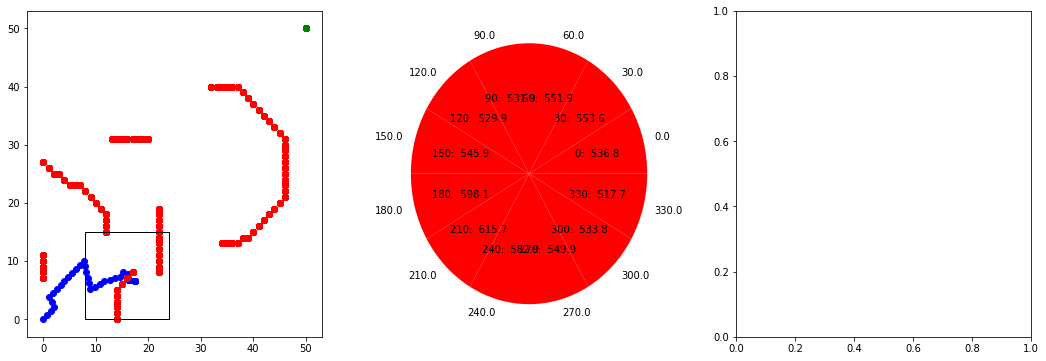

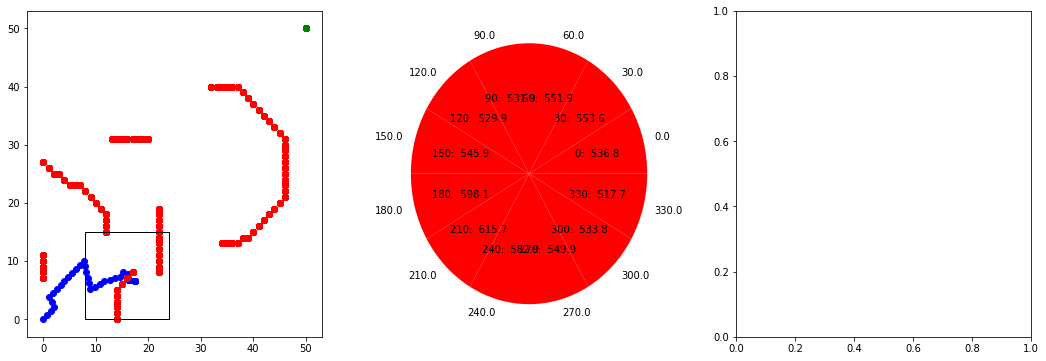

In [1]:
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%matplotlib inline


# from lib.polar_histogram import PolarHistogram
# from lib.histogram_grid import HistogramGrid
# from lib.path_planner import PathPlanner
from lib.robot import Robot

# HistogramGrid params
active_region_dimension = (16, 16)
resolution = 1 # 1cm per node
map_fname = 'map.txt'

# PolarHistogram params
num_bins = 12 # each bin is 36 degrees
target_location = (50, 50)

# Robot Params
init_location = (0, 0)
init_speed = 1

robot = Robot.from_map(map_fname, init_location, target_location, init_speed, active_region_dimension, resolution, num_bins)

num_steps = 100

robot.loop(num_steps, draw=True)
# print(path_planner)
# robot.path_planner.print_histogram()
# robot.draw()
# print(robot.angle)